In [1]:
%load_ext blackcellmagic

# Project 1  
## *The Moonshadow Elves*  
* Hongmei Zeng  
* Noah Stettler  
* Patrick Harrington  
* Yacub Bholat  
  
Due: 18 January 2020  

## Austin has seen explosive growth over the last several years.  
### * How has the *population* grown?  
### * How have *housing* prices changed?  
### * How has *employment* been affected?  
### * How have the *demographics* changed?  

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import requests
from sqlalchemy import create_engine
import pymysql
import api_keys

# global matplotlib formatting
matplotlib.rcParams["figure.figsize"] = [25, 10]
matplotlib.rcParams.update({"font.size": 14})

## Import Austin Population Data  

In [3]:
path = os.path.join("Data", "austinpop.csv")
population_df = pd.read_csv(path, header=None)
population_df.columns = ["Year", "Population", "Population Change"]
population_df = population_df.sort_values("Year").set_index("Year")

population_df.index = population_df.index.astype(str)
population_df["Population"] = population_df["Population"].astype(int)
population_df["Population Change"] = population_df["Population Change"].astype(int)

population_df

,Population,Population Change
Year,,
1990,465622,119732
2000,656562,190940
2010,806423,149861
2011,828694,22271
2012,854841,26147
2013,875463,20622
2014,901734,26271
2015,921545,19811
2016,939768,18223


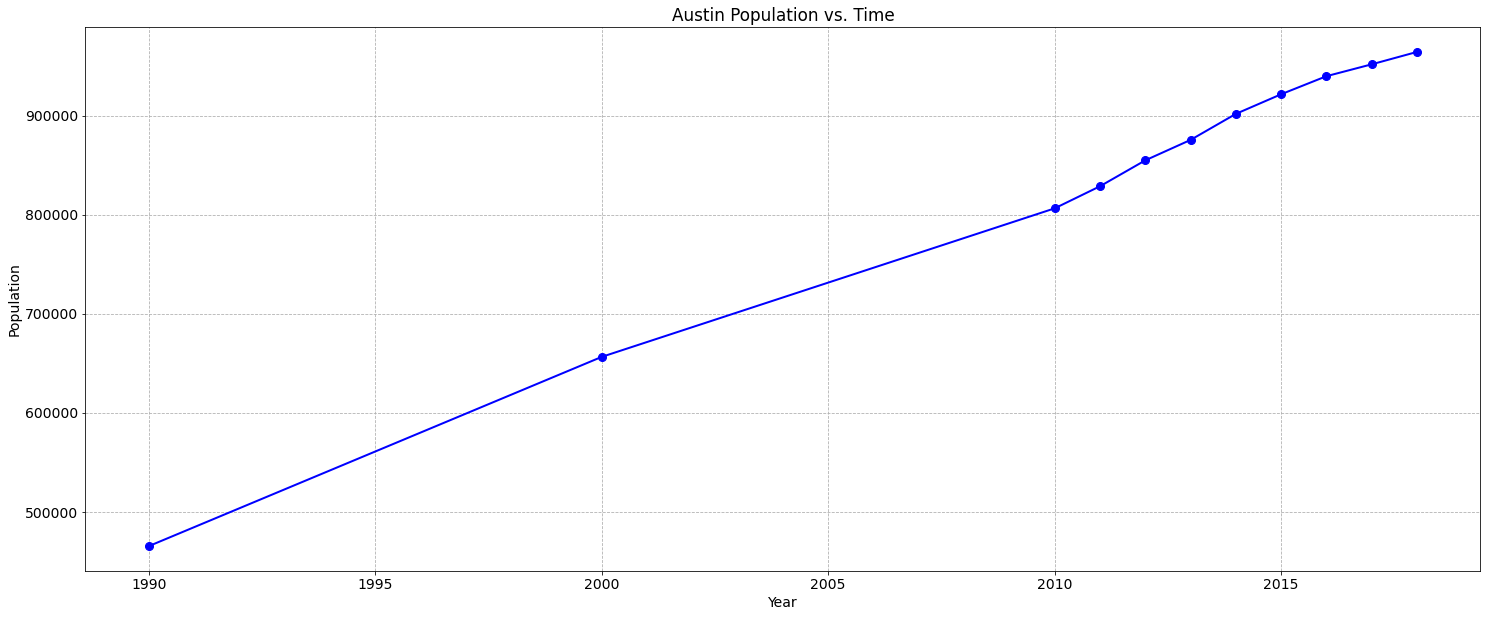

In [4]:
x = population_df.index.astype(int)
y = population_df["Population"]
plt.plot(x, y, color="blue", marker="o", linewidth=2, markersize=8)

plt.xlabel("Year")
plt.ylabel("Population")
plt.title("Austin Population vs. Time")
plt.grid(axis="both", linestyle="--")
plt.savefig(os.path.join("Images", "01 Austin Population Growth.png"))
plt.show()

## Authenticate Slipstream Home Junction API using Key  
* Get authentication token  
* Create header with token  

In [5]:
# documentation: https://slipstream.homejunction.com/#/ws/?id=authentication
path = "https://slipstream.homejunction.com/ws/api/authenticate"
payload = {"license": api_keys.slipstream_api_key}
r = requests.get(path, params=payload)

# extract slipstream authentication token and create headers dict
# documentation: https://slipstream.homejunction.com/#/ws/?id=tokens
token = r.json()["result"]["token"]
headers = {"HJI-Slipstream-Token": token}
r.status_code

200

## Get all Austin, TX zip codes from Slipstream Home Junction API  

In [6]:
# get all zip codes in austin, tx and associated zip code attributes
# documentation: https://slipstream.homejunction.com/#/ws/areas/zipcodes?id=search
path = "https://slipstream.homejunction.com/ws/areas/zipcodes/search"
payload = {
    "county": "travis",
    "state": "tx",
    "details": "true",
    "geometry": "true",
    "pageSize": "1000",
}
r = requests.get(path, params=payload, headers=headers)
r.status_code

200

In [7]:
r.json()

{'success': True,
 'result': {'total': 50,
  'zipcodes': [{'geoType': 'area/zipcode',
    'id': 'd4bb86ba102ac1c968962df78bc2a697',
    'name': '78774',
    'areaType': 'zipcode',
    'type': 'zipcode',
    'label': '78774, Austin, TX',
    'place': {'name': 'Austin'},
    'county': {'id': '1ac3868c36cd18fae9b5b3300e6f5383', 'name': 'Travis'},
    'state': {'id': '37d24c232b3fe1cf979241517be67a54',
     'name': 'Texas',
     'abbreviation': 'TX'},
    'zipType': 'Unique',
    'centroid': {'latitude': 30.278134, 'longitude': -97.738329},
    'internalPoint': {'latitude': 30.2781311721144,
     'longitude': -97.738329950132},
    'population': {'current': 13,
     '1990': 13,
     '2000': 15,
     '2010': 12,
     'density': 2252.6},
    'gender': {'male': 57.71, 'female': 42.29},
    'age': {'median': 32,
     'male': 34.3,
     'female': 27.8,
     'white': 33.8,
     'black': 42.9,
     'asian': 23.1,
     'hispanic': 25.8,
     'Y0_5': 1.71,
     'Y6_11': 1.99,
     'Y12_17': 1.42,
 

### Create series with Austin, TX zip codes  

In [8]:
# n = {zipcode['name'] : zipcode['geometry']['coordinates'] for zipcode in r.json()['result']['zipcodes']} # zip codes and lat/long data
zip_list = [
    int(zipcode["name"]) for zipcode in r.json()["result"]["zipcodes"]
]  # only zip codes
zip_list = pd.Series(zip_list)
zip_list.name = "ZipCode"
zip_list

0     78774
1     78755
2     78758
3     78669
4     78744
5     78736
6     78738
7     78719
8     78726
9     78653
10    78710
11    78733
12    78753
13    78722
14    78742
15    78725
16    78617
17    78732
18    78748
19    78705
20    78703
21    78756
22    78730
23    78728
24    78754
25    78735
26    78741
27    78731
28    78723
29    78724
30    78712
31    78645
32    78701
33    78751
34    78660
35    78734
36    78747
37    78727
38    78759
39    78750
40    78752
41    78745
42    78652
43    78704
44    78721
45    78739
46    78749
47    78746
48    78702
49    78757
Name: ZipCode, dtype: int64

## Create Austin, TX home sale dataframe  
* Import Zillow bulk data from CSV  
* Merge with zip code series  

In [9]:
zillow_sale_price_csv = os.path.join("Data", "Sale_Prices_Zip.csv")
zillow_df = (
    pd.read_csv(zillow_sale_price_csv)
    .drop(columns=["RegionID", "StateName", "SizeRank"])
    .rename(columns={"RegionName": "ZipCode"})
)
zillow_df = pd.merge(zillow_df, zip_list, how="inner", on="ZipCode")
zillow_df = zillow_df.set_index("ZipCode").transpose()
zillow_df

ZipCode,78660,78704,78745,78748,78758,78753,78759,78744,78723,78749,...,78754,78653,78752,78747,78739,78645,78732,78669,78721,78725
2008-03,NaN,304400.0,168200.0,177600.0,132300.0,134800.0,267600.0,NaN,189000.0,228300.0,...,NaN,NaN,NaN,NaN,318200.0,NaN,NaN,NaN,NaN,NaN
2008-04,NaN,295100.0,164300.0,171000.0,131200.0,130600.0,274500.0,NaN,200000.0,226700.0,...,NaN,NaN,NaN,NaN,318500.0,NaN,NaN,NaN,NaN,NaN
2008-05,NaN,275700.0,163500.0,175600.0,129300.0,124300.0,266600.0,NaN,191000.0,230400.0,...,NaN,NaN,NaN,NaN,306800.0,NaN,NaN,NaN,NaN,NaN
2008-06,NaN,283300.0,165400.0,172900.0,134000.0,123600.0,262400.0,NaN,178400.0,228900.0,...,NaN,NaN,NaN,NaN,311300.0,NaN,NaN,NaN,NaN,NaN
2008-07,NaN,284400.0,169000.0,175300.0,138600.0,126100.0,267700.0,NaN,185500.0,231700.0,...,NaN,NaN,NaN,NaN,323300.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07,254000.0,552900.0,328300.0,300200.0,281400.0,247700.0,449100.0,233300.0,377100.0,387500.0,...,250400.0,203200.0,326400.0,260600.0,482400.0,290600.0,513900.0,467500.0,346800.0,212500.0
2019-08,258500.0,590200.0,341200.0,297700.0,283900.0,251600.0,474300.0,237900.0,408800.0,398700.0,...,252400.0,205700.0,298700.0,272200.0,488600.0,286400.0,506900.0,491600.0,332200.0,207000.0
2019-09,257000.0,565500.0,342000.0,297600.0,281600.0,258100.0,464200.0,243400.0,409500.0,395100.0,...,256600.0,207100.0,307000.0,274600.0,493100.0,319000.0,496200.0,486900.0,341400.0,204800.0
2019-10,261200.0,566900.0,347700.0,306500.0,311200.0,267700.0,467700.0,245700.0,414600.0,382300.0,...,257800.0,204600.0,326400.0,282100.0,507700.0,319400.0,490600.0,452500.0,349400.0,204600.0


## Plot Home Sale Data  
* Define function to plot home sales

In [10]:
def plot_home_sale_data(df, title):
    df.plot()
    plt.legend(
        loc="upper left",
        bbox_to_anchor=(0, 1.0),
        ncol=int(np.ceil(len(df.columns) / 6)),
        fancybox=False,
        shadow=True,
    )
    plt.savefig(os.path.join("Images", title + ".png"))
    plt.xlabel("Sale Date")
    plt.ylabel("Sale Price ($)")
    plt.show()

* Plot data across all zip codes  

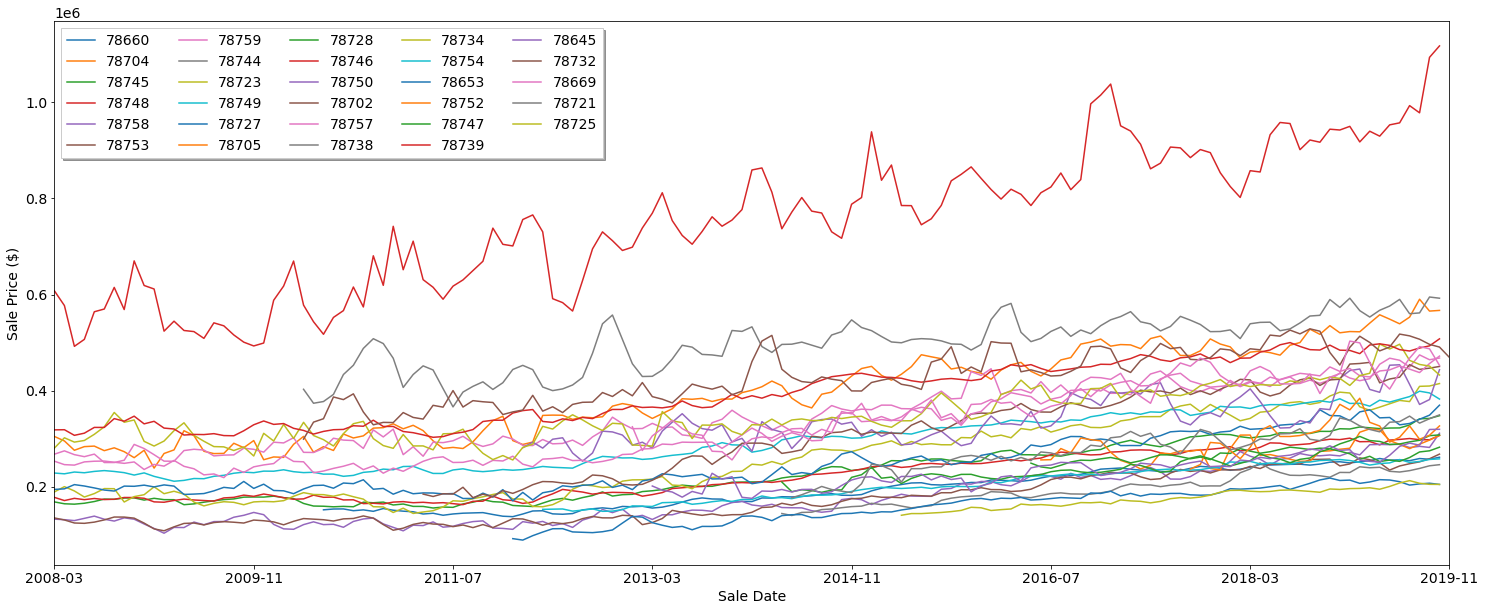

In [11]:
plot_home_sale_data(zillow_df, "02a Property Sale Price vs. Time by Zip Code (All)")

* Plot data for select zip codes  

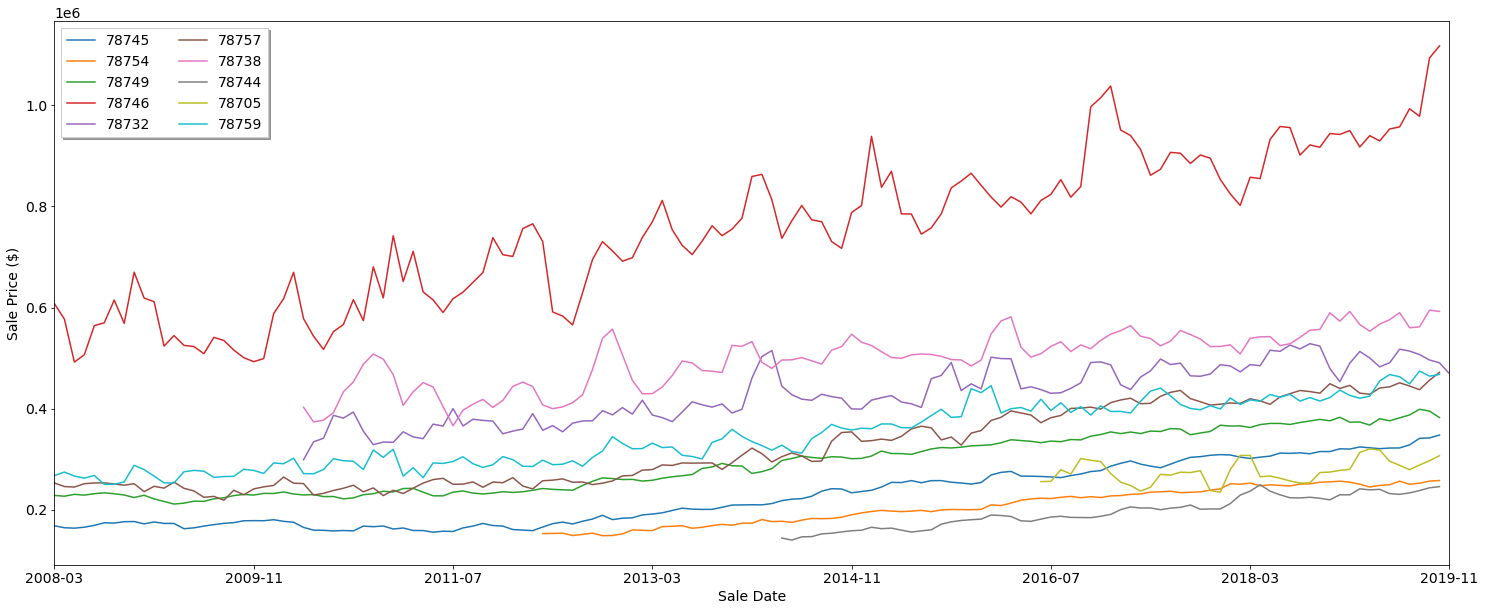

In [12]:
zillow_df_subset = zillow_df[
    [78745, 78754, 78749, 78746, 78732, 78757, 78738, 78744, 78705, 78759]
]
plot_home_sale_data(zillow_df_subset, "02b Property Sale Price vs. Time by Zip Code (Select)")

## Evaluate home sale data statistics  
* General home sale statistics by zip code  

In [13]:
zillow_df_statistics = zillow_df.describe()
zillow_df_statistics

ZipCode,78660,78704,78745,78748,78758,78753,78759,78744,78723,78749,...,78754,78653,78752,78747,78739,78645,78732,78669,78721,78725
count,113.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,67.000000,140.000000,140.000000,...,91.000000,94.000000,26.000000,67.000000,140.000000,80.000000,116.000000,82.000000,66.000000,55.000000
mean,195971.681416,392964.285714,226515.714286,220993.571429,175219.285714,170328.571429,345924.285714,195783.582090,255613.571429,290625.714286,...,207649.450549,161574.468085,309076.923077,237079.104478,393417.857143,232190.000000,430452.586207,379946.341463,276253.030303,175783.636364
std,40115.610760,92211.350970,59201.428224,47256.415515,55647.881790,48558.761089,63269.593174,30759.751334,80553.083807,57492.219519,...,35396.733602,35633.236075,34491.556157,23716.127599,65258.216791,33004.129393,56442.243602,60258.683499,44748.363854,19843.384602
min,137500.000000,238600.000000,155500.000000,162500.000000,103000.000000,108100.000000,250200.000000,139900.000000,144200.000000,211200.000000,...,148600.000000,88700.000000,236600.000000,188200.000000,302700.000000,175600.000000,298900.000000,255600.000000,176800.000000,140400.000000
25%,154400.000000,304550.000000,172300.000000,176325.000000,127475.000000,127025.000000,289775.000000,173700.000000,182400.000000,232900.000000,...,175750.000000,135800.000000,292200.000000,220750.000000,330425.000000,208250.000000,387225.000000,332900.000000,253725.000000,161450.000000
50%,196700.000000,383400.000000,209600.000000,208050.000000,154400.000000,148650.000000,332350.000000,190700.000000,238500.000000,285500.000000,...,208200.000000,172250.000000,306700.000000,234000.000000,385900.000000,228800.000000,428000.000000,373650.000000,281950.000000,174900.000000
75%,236200.000000,473275.000000,276175.000000,268100.000000,219475.000000,219475.000000,402650.000000,224200.000000,326100.000000,346200.000000,...,239900.000000,187325.000000,326400.000000,256800.000000,454100.000000,252800.000000,485350.000000,427700.000000,310325.000000,192450.000000
max,261200.000000,590200.000000,347700.000000,306500.000000,311200.000000,267700.000000,474300.000000,249500.000000,414600.000000,398700.000000,...,257800.000000,217900.000000,384000.000000,282100.000000,507700.000000,319400.000000,528500.000000,503000.000000,349400.000000,212500.000000


* Take the first difference of the home sale prices by zip code  
* Calculate mean and standard deviation of first difference df to determine volatility in home sales  

In [14]:
zillow_df_diff = zillow_df.diff()

zillow_df_diff_statistics = pd.DataFrame(
    {"mean": zillow_df_diff.mean(), "stdev": zillow_df_diff.std()}
)
zillow_df_diff_statistics

,mean,stdev
ZipCode,,
78660,977.678571,3138.620510
78704,1888.489209,16468.785050
78745,1291.366906,4293.262028
78748,927.338129,4001.481714
78758,1287.050360,8350.161281
78753,956.115108,5953.809097
78759,1439.568345,15489.354075
78744,1540.909091,5410.018549
78723,1623.021583,9172.211629


* Group the difference dataframe by month  

In [15]:
zillow_df_diff["Year"], zillow_df_diff["Month"] = zillow_df_diff.index.str.split("-", 1).str
zillow_df_diff["Month"] = zillow_df_diff["Month"].astype(int)
zillow_df_diff = zillow_df_diff.groupby(by="Month").mean()

* Calculate the mean of the home sale differences across all zip codes by month  

In [16]:
zillow_series_diff = zillow_df_diff.mean(axis=1)
zillow_series_diff

Month
1     2722.282181
2     -155.879858
3     1020.671120
4    -1197.357690
5     -631.334154
6     1245.433771
7     1804.547072
8     2190.759442
9     3378.175972
10    3344.321292
11    4227.309797
12     876.999925
dtype: float64

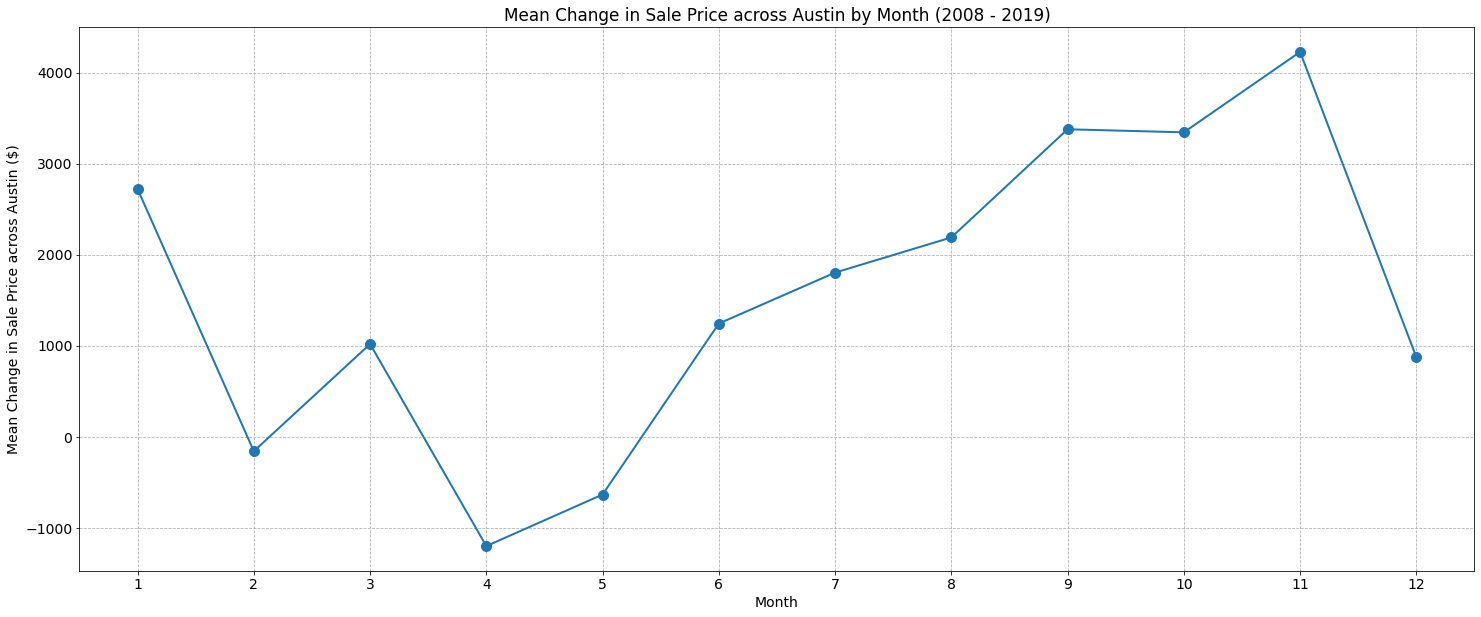

In [17]:
zillow_series_diff.plot(marker="o", linewidth=2, markersize=10)
plt.xlabel("Month")
plt.ylabel("Mean Change in Sale Price across Austin ($)")
plt.title("Mean Change in Sale Price across Austin by Month (2008 - 2019)")
plt.xlim(.5, 12.5)
plt.xticks(range(1,13))
plt.grid(axis="both", linestyle="--")
plt.savefig(os.path.join("Images", "03 Mean Change in Sale Price across Austin by Month (2008 - 2019).png"))
plt.show()

## Create a series with home sale data by year across all of Austin  
* First create a dataframe of home sale data by zip code and by year  
* Then create a series of home sale data for Austin by taking the median home sale value across all zip codes  

In [18]:
zillow_df_annual = zillow_df[[i[-2:] == "11" for i in zillow_df.index]]
zillow_df_annual.index = [i[:4] for i in zillow_df_annual.index]

zillow_series_annual_austin = pd.DataFrame(
    data=zillow_df_annual.median(axis=1), columns=["Median Home Sale Value"]
)
zillow_series_annual_austin.index.name = "Year"
zillow_series_annual_austin

,Median Home Sale Value
Year,
2008,224100.0
2009,229000.0
2010,237350.0
2011,232900.0
2012,236650.0
2013,263900.0
2014,273000.0
2015,277600.0
2016,297250.0


## Import Austin Employment Data  

In [19]:
path = os.path.join("Data", "SeriesReport-20200112162716_5da8f4.csv")
df = pd.read_csv(path)
df.head(20)

,Local Area Unemployment Statistics,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,Original Data Value,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,Series Id:,"LAUCT480500000000003,LAUCT480500000000004,LAUC...",NaN,NaN,NaN,NaN
3,Not Seasonally Adjusted,NaN,NaN,NaN,NaN,NaN
4,Area:,"Austin city, TX",NaN,NaN,NaN,NaN
5,Area Type:,"Cities and towns above 25,000 population",NaN,NaN,NaN,NaN
6,State/Region/Division:,Texas,NaN,NaN,NaN,NaN
7,Years:,2010 to 2019,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN
9,Year,Period,labor force,employment,unemployment,unemployment rate


In [20]:
df["Unnamed: 1"][2]

'LAUCT480500000000003,LAUCT480500000000004,LAUCT480500000000005,LAUCT480500000000006'

In [21]:
cleaned_df = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cleaned_df.head()

,Local Area Unemployment Statistics,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
10,2010,Jan,459941,429426,30515,6.6
11,2010,Feb,461604,432263,29341,6.4
12,2010,Mar,464429,435535,28894,6.2
13,2010,Apr,470021,441713,28308,6.0
14,2010,May,467577,439559,28018,6.0


In [22]:
names = {
    "Local Area Unemployment Statistics": "Year",
    "Unnamed: 1": "Month",
    "Unnamed: 2": "Labor Force",
    "Unnamed: 3": "Employment",
    "Unnamed: 4": "Unemployment",
    "Unnamed: 5": "Unemployment Rate %",
}
cleaned_df = cleaned_df.rename(columns=names)
cleaned_df = cleaned_df.reset_index(drop=True)
cleaned_df.tail(10)

,Year,Month,Labor Force,Employment,Unemployment,Unemployment Rate %
118,2019,Feb,588274,571850,16424,2.8
119,2019,Mar,587038,572088,14950,2.5
120,2019,Apr,585655,573240,12415,2.1
121,2019,May,585176,573123,12053,2.1
122,2019,Jun,588644,573957,14687,2.5
123,2019,Jul,588780,573254,15526,2.6
124,2019,Aug,584711,569621,15090,2.6
125,2019,Sep,590052,575793,14259,2.4
126,2019,Oct,594759,580749,14010,2.4
127,2019,Nov,597139,583073,14066,2.4


In [23]:
cleaned_df["Labor Force"] = cleaned_df["Labor Force"].astype("int")
cleaned_df["Employment"] = cleaned_df["Employment"].astype("int")
cleaned_df["Unemployment"] = cleaned_df["Unemployment"].astype("int")
cleaned_df["Unemployment Rate %"] = cleaned_df["Unemployment Rate %"].astype("float")

In [24]:
cleaned_df["Employment Rate %"] = (
    (cleaned_df["Employment"] / cleaned_df["Labor Force"]) * 100
).round(1)
cleaned_df.head(10)

,Year,Month,Labor Force,Employment,Unemployment,Unemployment Rate %,Employment Rate %
0,2010,Jan,459941,429426,30515,6.6,93.4
1,2010,Feb,461604,432263,29341,6.4,93.6
2,2010,Mar,464429,435535,28894,6.2,93.8
3,2010,Apr,470021,441713,28308,6.0,94.0
4,2010,May,467577,439559,28018,6.0,94.0
5,2010,Jun,469417,439255,30162,6.4,93.6
6,2010,Jul,469724,439522,30202,6.4,93.6
7,2010,Aug,470685,441294,29391,6.2,93.8
8,2010,Sep,471843,443168,28675,6.1,93.9
9,2010,Oct,474470,446328,28142,5.9,94.1


In [25]:
new_df = cleaned_df[
    [
        "Year",
        "Month",
        "Labor Force",
        "Employment",
        "Employment Rate %",
        "Unemployment",
        "Unemployment Rate %",
    ]
]
new_df.head(20)

,Year,Month,Labor Force,Employment,Employment Rate %,Unemployment,Unemployment Rate %
0,2010,Jan,459941,429426,93.4,30515,6.6
1,2010,Feb,461604,432263,93.6,29341,6.4
2,2010,Mar,464429,435535,93.8,28894,6.2
3,2010,Apr,470021,441713,94.0,28308,6.0
4,2010,May,467577,439559,94.0,28018,6.0
5,2010,Jun,469417,439255,93.6,30162,6.4
6,2010,Jul,469724,439522,93.6,30202,6.4
7,2010,Aug,470685,441294,93.8,29391,6.2
8,2010,Sep,471843,443168,93.9,28675,6.1
9,2010,Oct,474470,446328,94.1,28142,5.9


In [26]:
# Delete the Data of the year 2019
new_df = new_df[new_df.Year != "2019"]
new_df

,Year,Month,Labor Force,Employment,Employment Rate %,Unemployment,Unemployment Rate %
0,2010,Jan,459941,429426,93.4,30515,6.6
1,2010,Feb,461604,432263,93.6,29341,6.4
2,2010,Mar,464429,435535,93.8,28894,6.2
3,2010,Apr,470021,441713,94.0,28308,6.0
4,2010,May,467577,439559,94.0,28018,6.0
...,...,...,...,...,...,...,...
112,2018,Sep,580538,564680,97.3,15858,2.7
113,2018,Oct,581771,566677,97.4,15094,2.6
114,2018,Nov,583833,568948,97.5,14885,2.5
115,2018,Dec,583178,568316,97.5,14862,2.5


In [27]:
labor_yearly_df = new_df[new_df.Month == "Annual"].drop(columns=["Month"])
labor_yearly_df.set_index(["Year"], inplace=True)
labor_yearly_df

,Labor Force,Employment,Employment Rate %,Unemployment,Unemployment Rate %
Year,,,,,
2010,469287,440312,93.8,28975,6.2
2011,483618,455426,94.2,28192,5.8
2012,498207,473046,94.9,25161,5.1
2013,513750,489962,95.4,23788,4.6
2014,528511,508899,96.3,19612,3.7
2015,537448,521407,97.0,16041,3.0
2016,555755,538632,96.9,17123,3.1
2017,561212,544462,97.0,16750,3.0
2018,579048,563154,97.3,15894,2.7


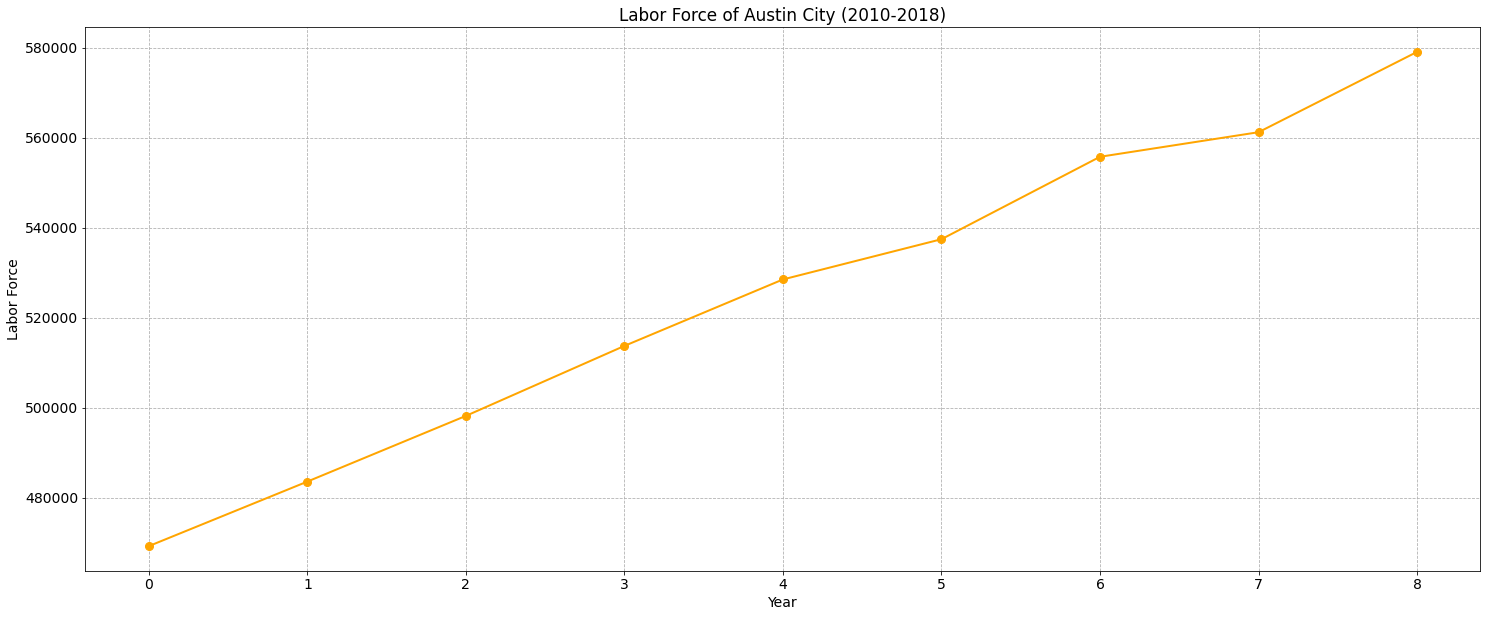

In [90]:
x = labor_yearly_df.index
y = labor_yearly_df["Labor Force"]
plt.plot(x, y, color="orange", marker="o", linewidth=2, markersize=8)
plt.xlabel("Year")
plt.ylabel("Labor Force")
plt.title("Labor Force of Austin City (2010-2018)")
plt.grid(axis="both", linestyle="--")
plt.savefig(os.path.join("Images", "04a Employment Amount.png"))
plt.show()

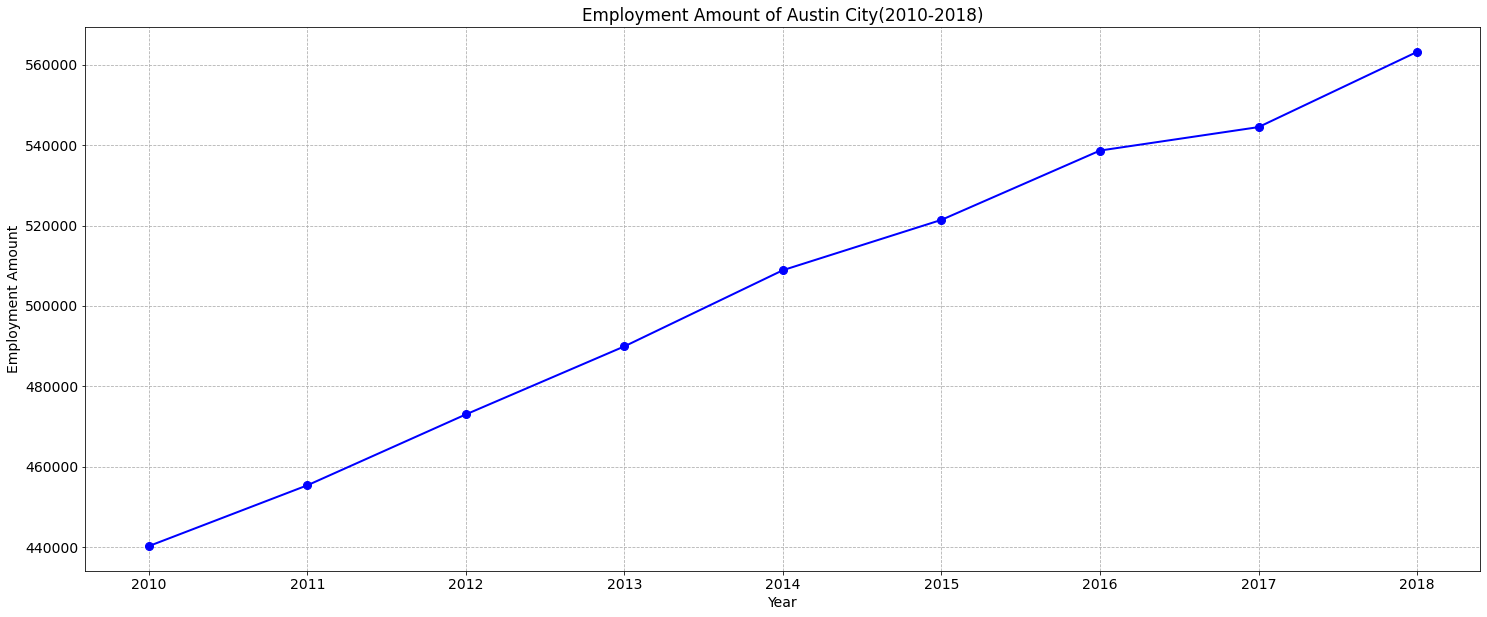

In [29]:
x = labor_yearly_df.index
y = labor_yearly_df["Employment"]
plt.plot(x, y, color="blue", marker="o", linewidth=2, markersize=8)

plt.xlabel("Year")
plt.ylabel("Employment Amount")
plt.title("Employment Amount of Austin City (2010-2018)")
plt.grid(axis="both", linestyle="--")
plt.savefig(os.path.join("Images", "04b Employment Amount.png"))
plt.show()

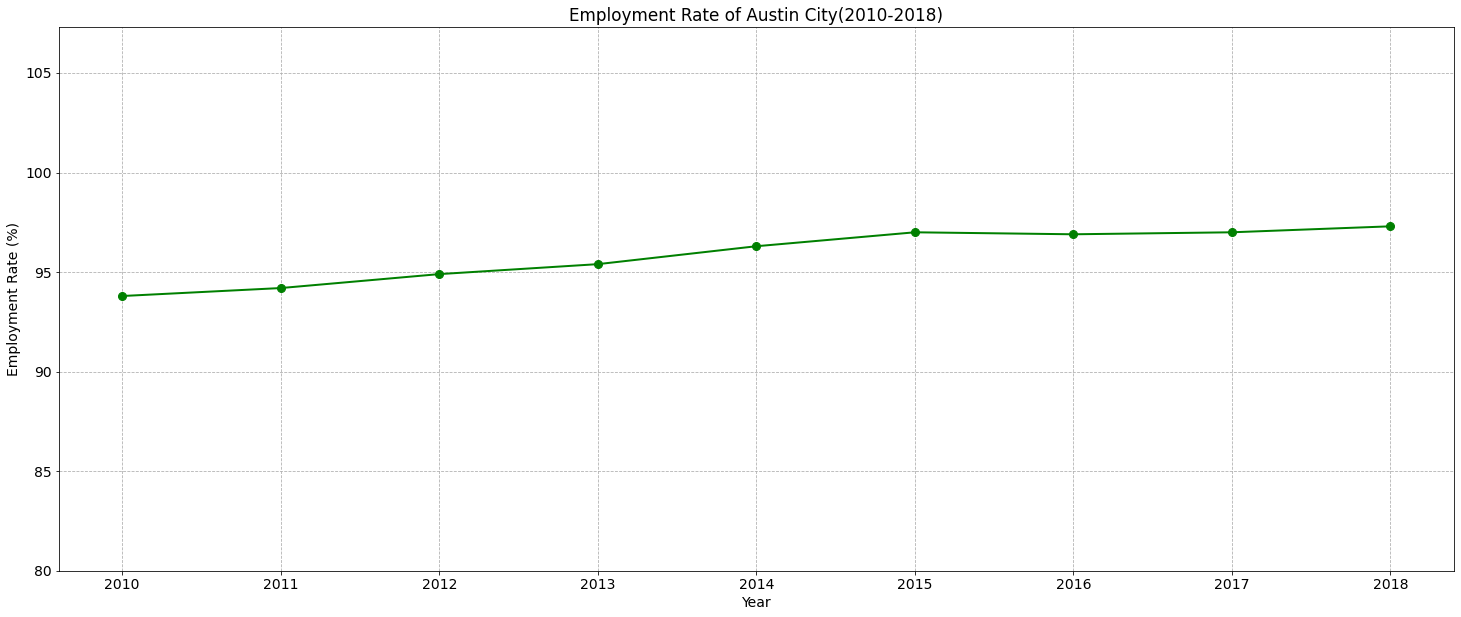

In [30]:
x = labor_yearly_df.index
y = labor_yearly_df["Employment Rate %"]
plt.plot(x, y, color="green", marker="o", linewidth=2, markersize=8)

plt.xlabel("Year")
plt.ylabel("Employment Rate (%)")
plt.title("Employment Rate of Austin City(2010-2018)")
plt.ylim(80, max(y) + 10)
plt.grid(axis="both", linestyle="--")
plt.savefig(os.path.join("Images", "05 Employment Rate.png"))
plt.show()

In [31]:
monthly_df = new_df[new_df.Month != "Annual"]
monthly_df

,Year,Month,Labor Force,Employment,Employment Rate %,Unemployment,Unemployment Rate %
0,2010,Jan,459941,429426,93.4,30515,6.6
1,2010,Feb,461604,432263,93.6,29341,6.4
2,2010,Mar,464429,435535,93.8,28894,6.2
3,2010,Apr,470021,441713,94.0,28308,6.0
4,2010,May,467577,439559,94.0,28018,6.0
...,...,...,...,...,...,...,...
111,2018,Aug,576321,559684,97.1,16637,2.9
112,2018,Sep,580538,564680,97.3,15858,2.7
113,2018,Oct,581771,566677,97.4,15094,2.6
114,2018,Nov,583833,568948,97.5,14885,2.5


In [32]:
monthly_employment_df = pd.pivot_table(
    monthly_df, index="Year", columns="Month", values="Employment"
)
monthly_employment_df = monthly_employment_df[
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
]
monthly_employment_df

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2010,429426,432263,435535,441713,439559,439255,439522,441294,443168,446328,448216,447466
2011,446369,450065,452269,455625,454697,452557,452304,454077,457796,461506,464337,463515
2012,463553,466017,468070,469982,470140,470366,470619,470441,477432,482280,484754,482892
2013,479852,482261,483724,489336,489848,489323,489982,489587,493319,492863,500207,499243
2014,500177,503872,507006,508974,507846,508482,508256,506943,510125,514479,516559,514066
2015,510475,513302,515701,520475,521735,521578,520295,520121,523475,526935,531147,531639
2016,527768,532700,534942,537069,536757,538017,539924,537855,541457,544403,546911,545780
2017,532823,537363,539351,543231,542377,543207,545644,542757,550443,550725,552736,552882
2018,553965,560332,560393,563090,563062,563320,565383,559684,564680,566677,568948,568316


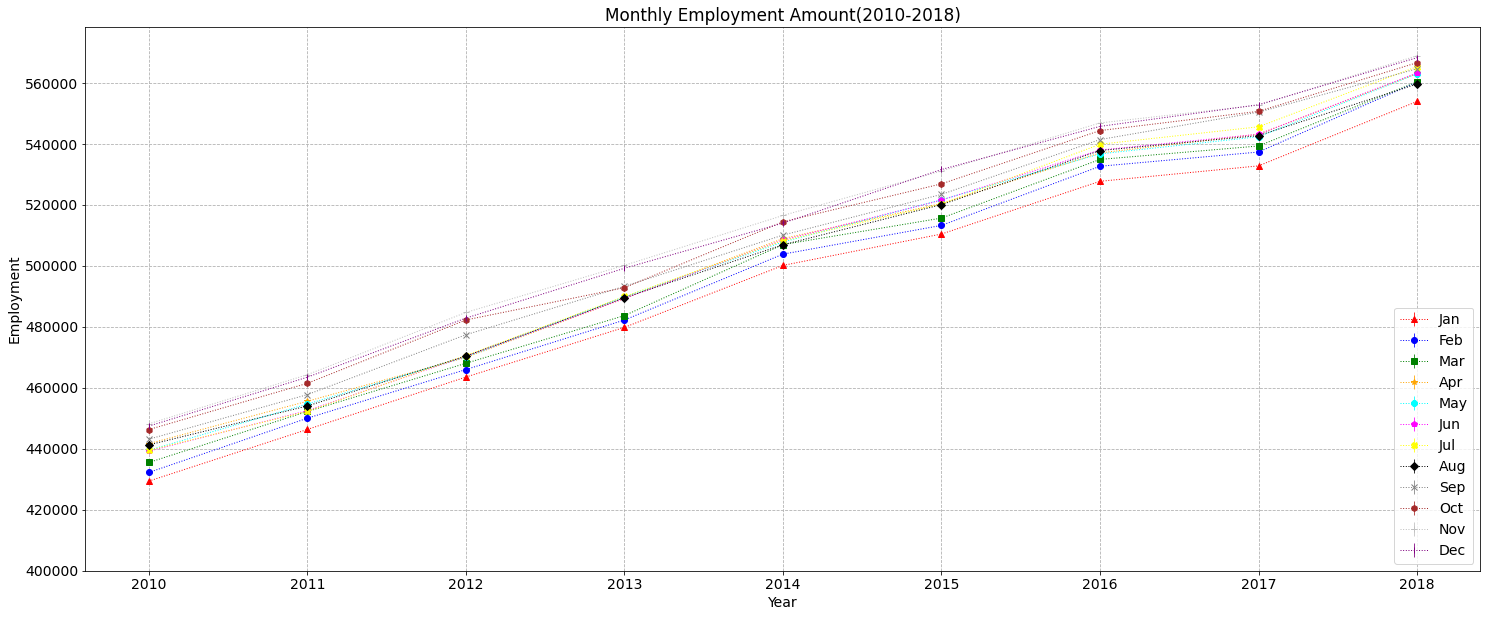

In [33]:
colors = [
    "red",
    "blue",
    "green",
    "orange",
    "cyan",
    "magenta",
    "yellow",
    "black",
    "grey",
    "brown",
    "silver",
    "purple",
]
markers = ["^", "o", "s", "*", "8", "p", "X", "D", "x", "h", "+", "|"]

x = monthly_employment_df.index
for column, i in zip(
    monthly_employment_df.columns, range(len(monthly_employment_df.columns))
):
    y = monthly_employment_df[column]
    plt.errorbar(
        x,
        y,
        yerr=3,
        elinewidth=0.8,
        color=colors[i],
        marker=markers[i],
        linestyle=":",
        linewidth=1,
        errorevery=1,
        label=column,
    )

plt.xlabel("Year")
plt.ylabel("Employment")
plt.title("Monthly Employment Amount(2010-2018)")
plt.legend(loc="lower right")
plt.ylim(400000, max(y) + 10000)
plt.grid(axis="both", linestyle="--")
plt.savefig(os.path.join("Images", "06 Monthly Employment Amount.png"))
plt.show()

In [34]:
monthly_employment_rate_df = pd.pivot_table(
    monthly_df, index="Year", columns="Month", values="Employment Rate %"
)
monthly_employment_rate_df = monthly_employment_rate_df[
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
]
monthly_employment_rate_df

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2010,93.4,93.6,93.8,94.0,94.0,93.6,93.6,93.8,93.9,94.1,94.0,94.3
2011,93.9,94.1,94.3,94.4,94.3,93.7,93.7,93.9,93.9,94.3,94.7,94.9
2012,94.5,94.7,94.9,95.2,95.0,94.5,94.5,94.8,95.2,95.3,95.5,95.4
2013,94.7,95.1,95.3,95.6,95.4,94.9,95.0,95.3,95.4,95.5,95.9,96.2
2014,95.9,96.0,96.1,96.7,96.3,96.1,95.9,96.0,96.3,96.5,96.7,97.0
2015,96.6,96.9,97.1,97.3,97.0,96.9,96.8,97.0,97.0,97.1,97.2,97.3
2016,96.9,97.0,97.0,97.3,97.2,96.8,96.6,96.7,96.7,96.8,96.9,97.0
2017,96.6,96.7,96.9,97.2,97.1,96.9,96.9,96.8,97.1,97.3,97.2,97.3
2018,97.1,97.1,97.1,97.4,97.5,97.0,97.1,97.1,97.3,97.4,97.5,97.5


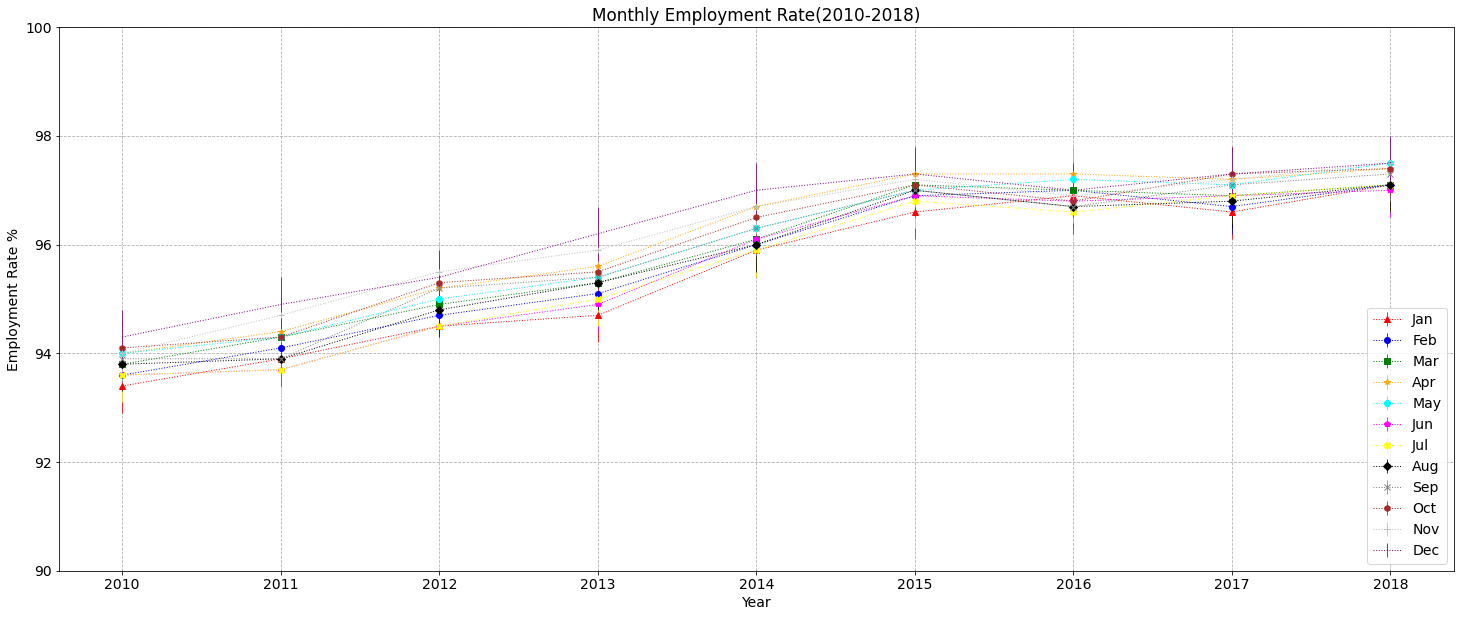

In [35]:
colors = [
    "red",
    "blue",
    "green",
    "orange",
    "cyan",
    "magenta",
    "yellow",
    "black",
    "grey",
    "brown",
    "silver",
    "purple",
]
markers = ["^", "o", "s", "*", "8", "p", "X", "D", "x", "h", "+", ","]

x = monthly_employment_rate_df.index
for column, i in zip(
    monthly_employment_rate_df.columns, range(len(monthly_employment_rate_df.columns))
):
    y = monthly_employment_rate_df[column]
    plt.errorbar(
        x,
        y,
        yerr=0.5,
        elinewidth=0.8,
        color=colors[i],
        marker=markers[i],
        linestyle=":",
        linewidth=1,
        errorevery=1,
        label=column,
    )

plt.xlabel("Year")
plt.ylabel("Employment Rate %")
plt.title("Monthly Employment Rate(2010-2018)")
plt.legend(loc="lower right")
plt.ylim(90, max(y) + 2.5)
plt.grid(axis="both", linestyle="--")
plt.savefig(os.path.join("Images", "07 Monthly Employment Rate.png"))
plt.show()

In [36]:
monthly_df

,Year,Month,Labor Force,Employment,Employment Rate %,Unemployment,Unemployment Rate %
0,2010,Jan,459941,429426,93.4,30515,6.6
1,2010,Feb,461604,432263,93.6,29341,6.4
2,2010,Mar,464429,435535,93.8,28894,6.2
3,2010,Apr,470021,441713,94.0,28308,6.0
4,2010,May,467577,439559,94.0,28018,6.0
...,...,...,...,...,...,...,...
111,2018,Aug,576321,559684,97.1,16637,2.9
112,2018,Sep,580538,564680,97.3,15858,2.7
113,2018,Oct,581771,566677,97.4,15094,2.6
114,2018,Nov,583833,568948,97.5,14885,2.5


In [37]:
monthly_df = monthly_df.assign(Year_Month = monthly_df['Year'] + '-' + monthly_df['Month'])
monthly_df

,Year,Month,Labor Force,Employment,Employment Rate %,Unemployment,Unemployment Rate %,Year_Month
0,2010,Jan,459941,429426,93.4,30515,6.6,2010-Jan
1,2010,Feb,461604,432263,93.6,29341,6.4,2010-Feb
2,2010,Mar,464429,435535,93.8,28894,6.2,2010-Mar
3,2010,Apr,470021,441713,94.0,28308,6.0,2010-Apr
4,2010,May,467577,439559,94.0,28018,6.0,2010-May
...,...,...,...,...,...,...,...,...
111,2018,Aug,576321,559684,97.1,16637,2.9,2018-Aug
112,2018,Sep,580538,564680,97.3,15858,2.7,2018-Sep
113,2018,Oct,581771,566677,97.4,15094,2.6,2018-Oct
114,2018,Nov,583833,568948,97.5,14885,2.5,2018-Nov


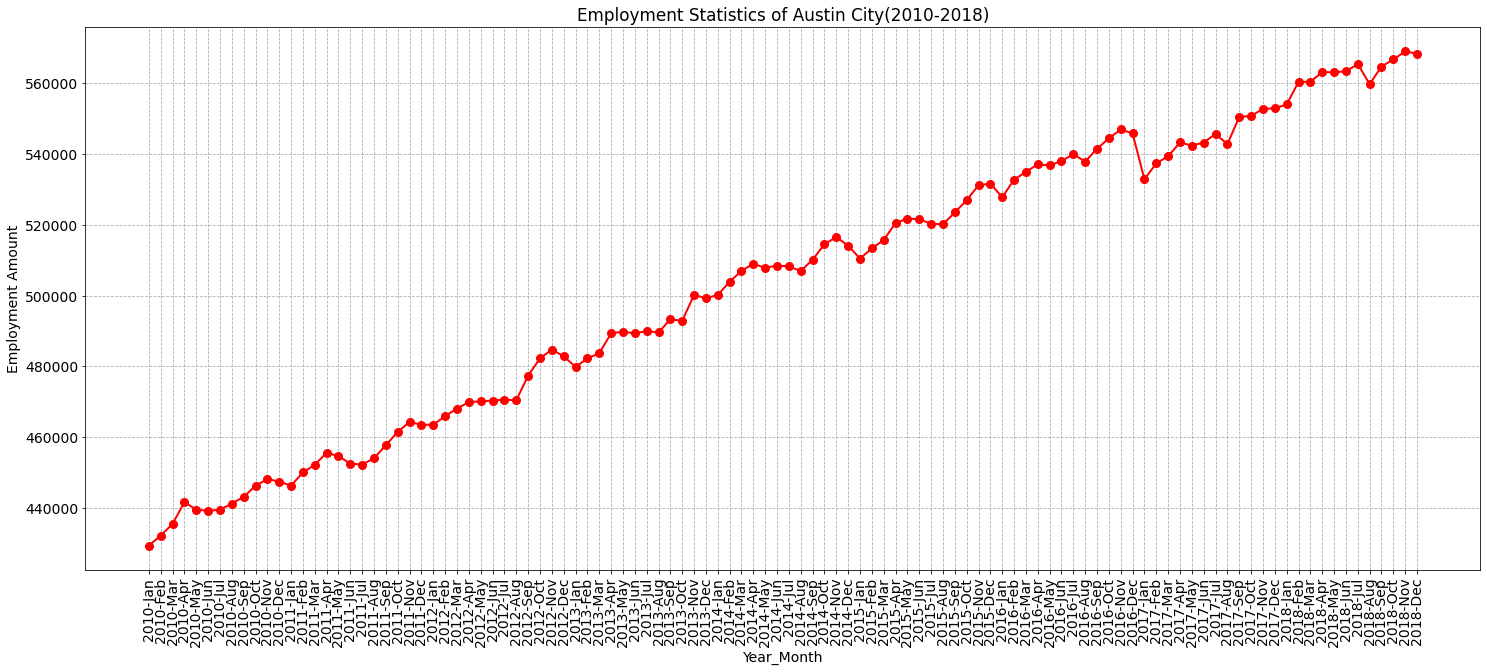

In [38]:
x = monthly_df["Year_Month"]
y = monthly_df["Employment"]
plt.plot(x, y, color="red", marker="o", linewidth=2, markersize=8)

plt.xlabel("Year_Month")
plt.xticks(rotation=90)
plt.ylabel("Employment Amount")
plt.title("Employment Statistics of Austin City(2010-2018)")
plt.grid(axis="both", linestyle="--")
plt.savefig(os.path.join("Images", "08 Employment Statistics.png"))
plt.show()

# Demographic Data Per Decade  

In [39]:
path = os.path.join("Data", "austin_demographics.csv")
df = df = pd.read_csv(path)
df.columns

Index(['Data Item', '1990', '2000', '2010', '2018'], dtype='object')

In [40]:
df

,Data Item,1990,2000,2010,2018
0,Total Population,465622.00,656562.00,790390.00,964243.00
1,Non-Hispanic White,287289.00,347554.00,385271.00,452110.00
2,African-American,55409.00,64259.00,60760.00,69770.00
3,Hispanic-Latino,106162.00,200579.00,277709.00,320562.00
4,Asian,15366.00,30915.00,49506.00,68181.00
5,American Indian,NaN,1854.00,1967.00,1591.00
6,Multi-Racial,NaN,10158.00,13677.00,21847.00
7,Other,1397.00,1243.00,1448.00,1694.00
8,Under 5,7.60,7.10,7.30,6.27
9,5 to 17,15.50,15.40,14.90,13.46


### Growth Rate Functions  

In [41]:
def growth(f, s):
    f = np.array(f)
    s = np.array(s)
    ag = ((f - s) / s) * 100
    return ag


def percent_to_units1990(p):
    u = (p * 0.01) * df["1990"][0]
    return u


def percent_to_units2000(p):
    u = (p * 0.01) * df["2000"][0]
    return u


def percent_to_units2010(p):
    u = (p * 0.01) * df["2010"][0]
    return u


def percent_to_units2018(p):
    u = (p * 0.01) * df["2018"][0]
    return u

## Race  

In [42]:
def race(df):
    r = df["Data Item"][0:8].tolist()
    return r


def race_year1(df):
    y = df["1990"][0:8].tolist()
    return y


def race_year2(df):
    y = df["2000"][0:8].tolist()
    return y


def race_year3(df):
    y = df["2010"][0:8].tolist()
    return y


def race_year4(df):
    y = df["2018"][0:8].tolist()
    return y

In [43]:
demo = race(df)
r1 = race_year1(df)
r2 = race_year2(df)
r3 = race_year3(df)
r4 = race_year4(df)
race_demo = pd.DataFrame(
    [
        {
            "Year": 1990,
            demo[0]: r1[0],
            demo[1]: r1[1],
            demo[2]: r1[2],
            demo[3]: r1[3],
            demo[4]: r1[4],
            demo[5]: r1[5],
            demo[6]: r1[6],
            demo[7]: r1[7],
        },
        {
            "Year": 2000,
            demo[0]: r2[0],
            demo[1]: r2[1],
            demo[2]: r2[2],
            demo[3]: r2[3],
            demo[4]: r2[4],
            demo[5]: r2[5],
            demo[6]: r2[6],
            demo[7]: r2[7],
        },
        {
            "Year": 2010,
            demo[0]: r3[0],
            demo[1]: r3[1],
            demo[2]: r3[2],
            demo[3]: r3[3],
            demo[4]: r3[4],
            demo[5]: r3[5],
            demo[6]: r3[6],
            demo[7]: r3[7],
        },
        {
            "Year": 2018,
            demo[0]: r4[0],
            demo[1]: r4[1],
            demo[2]: r4[2],
            demo[3]: r4[3],
            demo[4]: r4[4],
            demo[5]: r4[5],
            demo[6]: r4[6],
            demo[7]: r4[7],
        },
    ]
).set_index("Year")
race_demo

,Total Population,Non-Hispanic White,African-American,Hispanic-Latino,Asian,American Indian,Multi-Racial,Other
Year,,,,,,,,
1990,465622.0,287289.0,55409.0,106162.0,15366.0,NaN,NaN,1397.0
2000,656562.0,347554.0,64259.0,200579.0,30915.0,1854.0,10158.0,1243.0
2010,790390.0,385271.0,60760.0,277709.0,49506.0,1967.0,13677.0,1448.0
2018,964243.0,452110.0,69770.0,320562.0,68181.0,1591.0,21847.0,1694.0


In [44]:
race_demo_percent = race_demo.div(race_demo["Total Population"], axis=0).drop(columns=["Total Population"]) * 100
race_demo_percent

,Non-Hispanic White,African-American,Hispanic-Latino,Asian,American Indian,Multi-Racial,Other
Year,,,,,,,
1990,61.700049,11.899996,22.800040,3.300102,NaN,NaN,0.300029
2000,52.935443,9.787195,30.549895,4.708619,0.282380,1.547150,0.189320
2010,48.744417,7.687344,35.135693,6.263490,0.248864,1.730412,0.183201
2018,46.887558,7.235728,33.244939,7.070935,0.165000,2.265715,0.175682


In [45]:
race_demo = race_demo.apply(pd.to_numeric)

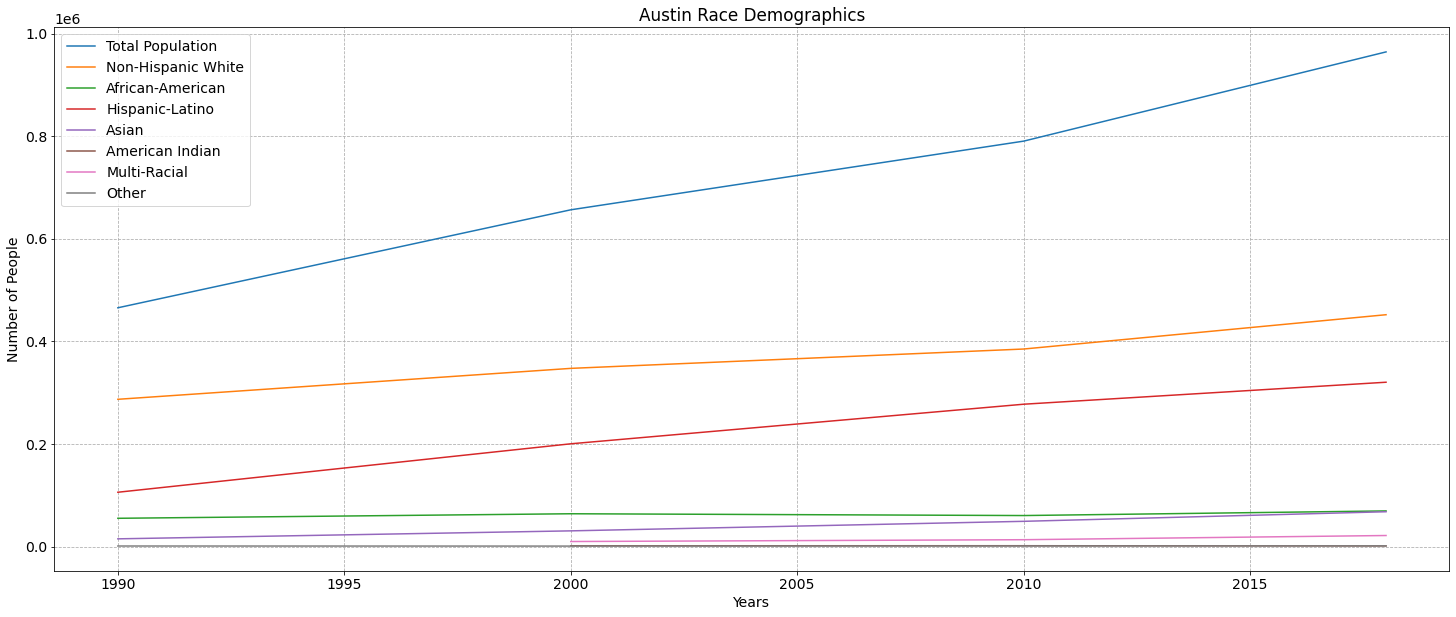

In [46]:
# Incorporate the other graph properties
plt.title("Austin Race Demographics")
plt.ylabel("Number of People")
plt.xlabel("Years")
plt.grid(axis="both", linestyle="--")
plt.plot(race_demo)
plt.legend(labels=race_demo.columns)

# Save the figure
plt.savefig(os.path.join("Images", "09 Race Demographics.png"))

# Show plot
plt.show()

In [47]:
rg1 = growth(df["2000"][0:8], df["1990"][0:8]).tolist()
rg2 = growth(df["2010"][0:8], df["2000"][0:8]).tolist()
rg3 = growth(df["2018"][0:8], df["2010"][0:8]).tolist()
race_growth = pd.DataFrame(
    [
        {
            "Year": 1990,
            demo[0]: 0,
            demo[1]: 0,
            demo[2]: 0,
            demo[3]: 0,
            demo[4]: 0,
            demo[5]: 0,
            demo[6]: 0,
            demo[7]: 0,
        },
        {
            "Year": 2000,
            demo[0]: rg1[0],
            demo[1]: rg1[1],
            demo[2]: rg1[2],
            demo[3]: rg1[3],
            demo[4]: rg1[4],
            demo[5]: rg1[5],
            demo[6]: rg1[6],
            demo[7]: rg1[7],
        },
        {
            "Year": 2010,
            demo[0]: rg2[0],
            demo[1]: rg2[1],
            demo[2]: rg2[2],
            demo[3]: rg2[3],
            demo[4]: rg2[4],
            demo[5]: rg2[5],
            demo[6]: rg2[6],
            demo[7]: rg2[7],
        },
        {
            "Year": 2018,
            demo[0]: rg3[0],
            demo[1]: rg3[1],
            demo[2]: rg3[2],
            demo[3]: rg3[3],
            demo[4]: rg3[4],
            demo[5]: rg3[5],
            demo[6]: rg3[6],
            demo[7]: rg3[7],
        },
    ]
).set_index("Year")
race_growth

,Total Population,Non-Hispanic White,African-American,Hispanic-Latino,Asian,American Indian,Multi-Racial,Other
Year,,,,,,,,
1990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000,41.007513,20.977135,15.972134,88.936719,101.190941,NaN,NaN,-11.023622
2010,20.383147,10.852127,-5.445152,38.453677,60.135856,6.094930,34.642646,16.492357
2018,21.995850,17.348568,14.828835,15.430901,37.722700,-19.115404,59.735322,16.988950


In [48]:
race_growth = race_growth.apply(pd.to_numeric)

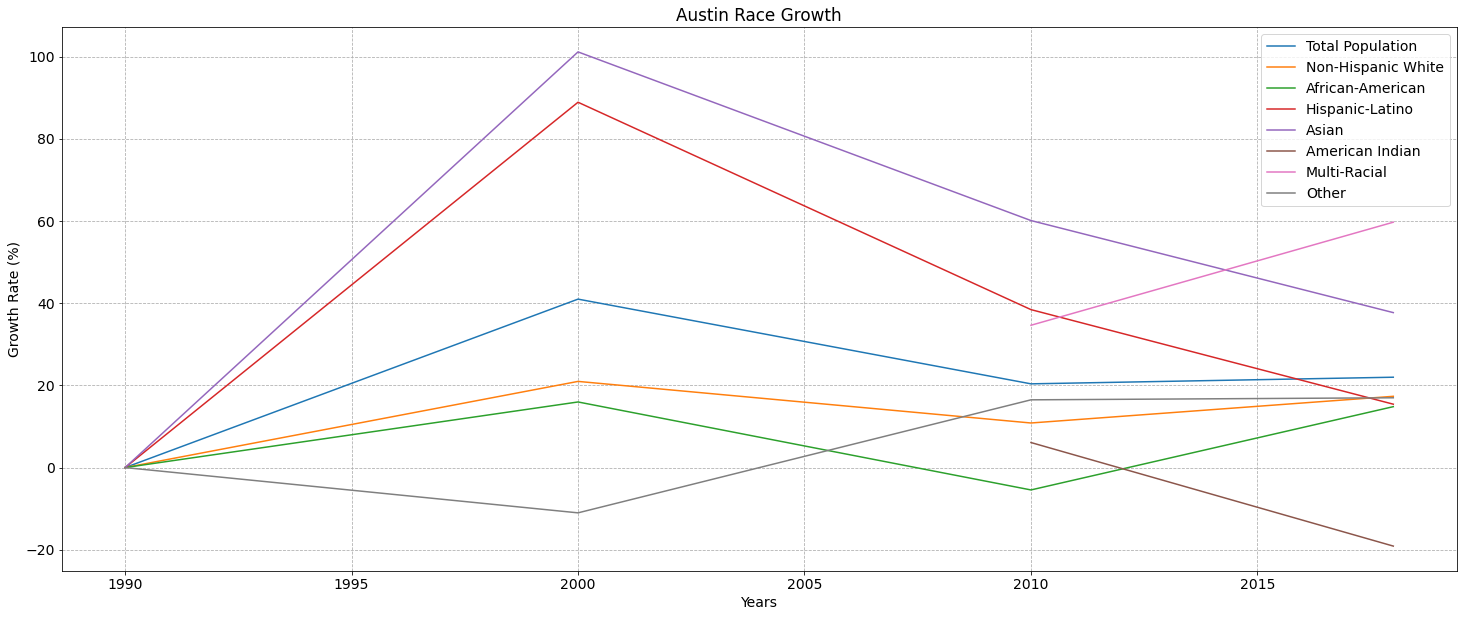

In [49]:
# Incorporate the other graph properties
plt.title("Austin Race Growth")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Years")
plt.grid(axis="both", linestyle="--")
plt.plot(race_growth)
plt.legend(labels=race_growth.columns)

plt.savefig(os.path.join("Images", "10 Race Growth.png"))

# Show plot
plt.show()

## Age  

In [50]:
def age(df):
    r = df["Data Item"][8:17].tolist()
    return r


def age_year1(df):
    y = df["1990"][8:17].tolist()
    return y


def age_year2(df):
    y = df["2000"][8:17].tolist()
    return y


def age_year3(df):
    y = df["2010"][8:17].tolist()
    return y


def age_year4(df):
    y = df["2018"][8:17].tolist()
    return y

In [51]:
demo2 = age(df)
a1 = age_year1(df)
a2 = age_year2(df)
a3 = age_year3(df)
a4 = age_year4(df)
age_demo = pd.DataFrame(
    [
        {
            "Year": 1990,
            demo2[0]: a1[0],
            demo2[1]: a1[1],
            demo2[2]: a1[2],
            demo2[3]: a1[3],
            demo2[4]: a1[4],
            demo2[5]: a1[5],
            demo2[6]: a1[6],
            demo2[7]: a1[7],
        },
        {
            "Year": 2000,
            demo2[0]: a2[0],
            demo2[1]: a2[1],
            demo2[2]: a2[2],
            demo2[3]: a2[3],
            demo2[4]: a2[4],
            demo2[5]: a2[5],
            demo2[6]: a2[6],
            demo2[7]: a2[7],
        },
        {
            "Year": 2010,
            demo2[0]: a3[0],
            demo2[1]: a3[1],
            demo2[2]: a3[2],
            demo2[3]: a3[3],
            demo2[4]: a3[4],
            demo2[5]: a3[5],
            demo2[6]: a3[6],
            demo2[7]: a3[7],
        },
        {
            "Year": 2018,
            demo2[0]: a4[0],
            demo2[1]: a4[1],
            demo2[2]: a4[2],
            demo2[3]: a4[3],
            demo2[4]: a4[4],
            demo2[5]: a4[5],
            demo2[6]: a4[6],
            demo2[6]: a4[6],
            demo2[7]: a4[7],
        },
    ]
).set_index("Year")
age_demo
# Values in Percent

,Under 5,5 to 17,18 to 24,25 to 34,35 to 44,45 to 54,55 to 64,Over 65
Year,,,,,,,,
1990,7.60,15.50,17.7,22.70,15.6,7.90,5.60,7.40
2000,7.10,15.40,16.6,21.10,16.0,11.60,5.60,6.70
2010,7.30,14.90,14.5,20.70,14.8,12.10,8.70,7.00
2018,6.27,13.46,10.4,22.74,15.6,11.87,10.34,9.36


In [52]:
median_age = pd.DataFrame(
    [
        {"Year": 1990, demo2[8]: a1[8]},
        {"Year": 2000, demo2[8]: a2[8]},
        {"Year": 2010, demo2[8]: a3[8]},
        {"Year": 2018, demo2[8]: a4[8]},
    ]
).set_index("Year")
median_age

,Median Age
Year,
1990,28.3
2000,29.6
2010,31.0
2018,32.0


In [53]:
age_demo = age_demo.apply(pd.to_numeric)
median_age = median_age.apply(pd.to_numeric)

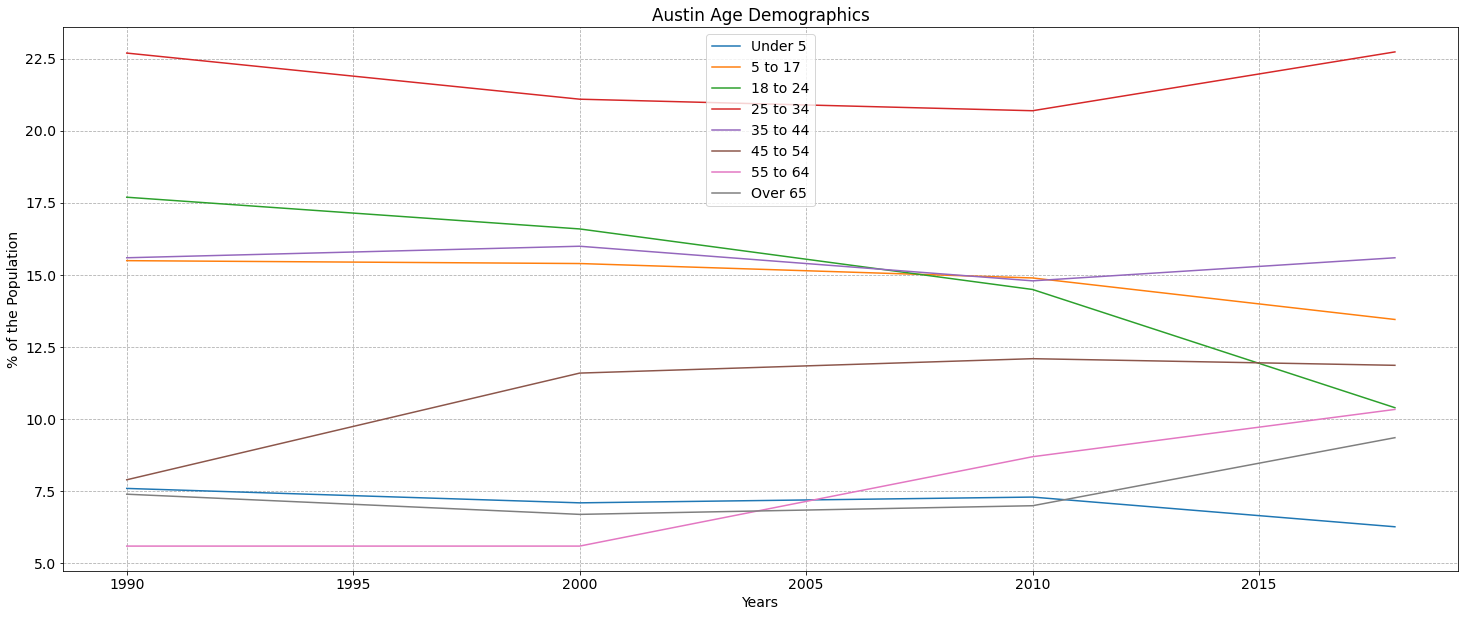

In [54]:
# Incorporate the other graph properties
plt.title("Austin Age Demographics")
plt.ylabel("% of the Population")
plt.xlabel("Years")
plt.grid(axis="both", linestyle="--")
plt.plot(age_demo)
plt.legend(labels=age_demo.columns)

plt.savefig(os.path.join("Images", "11 Age Demographics.png"))
plt.show()

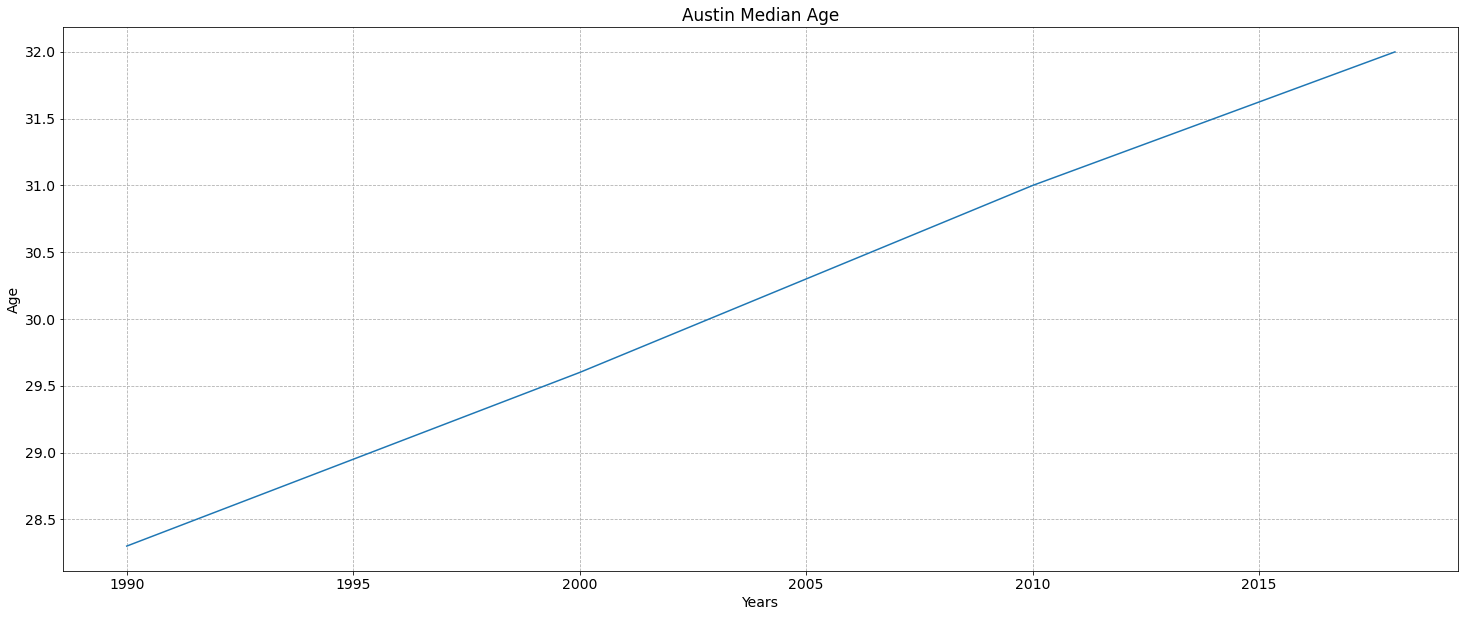

In [55]:
# Incorporate the other graph properties
plt.title("Austin Median Age")
plt.ylabel("Age")
plt.xlabel("Years")
plt.grid(axis="both", linestyle="--")
plt.plot(median_age)

plt.savefig(os.path.join("Images", "12 Median Age.png"))
plt.show()

In [56]:
ac1 = percent_to_units1990(df["1990"][8:17]).tolist()
ac2 = percent_to_units2000(df["2000"][8:17]).tolist()
ac3 = percent_to_units2010(df["2010"][8:17]).tolist()
ac4 = percent_to_units2018(df["2018"][8:17]).tolist()
ag1 = growth(ac2[0:8], ac1[0:8]).tolist()
ag2 = growth(ac3[0:8], ac2[0:8]).tolist()
ag3 = growth(ac4[0:8], ac3[0:8]).tolist()
mag1 = growth(df["2000"][16], df["1990"][16])
mag2 = growth(df["2010"][16], df["2000"][16])
mag3 = growth(df["2018"][16], df["2010"][16])
age_growth = pd.DataFrame(
    [
        {
            "Year": 1990,
            demo2[0]: 0,
            demo2[1]: 0,
            demo2[2]: 0,
            demo2[3]: 0,
            demo2[4]: 0,
            demo2[5]: 0,
            demo2[6]: 0,
            demo2[7]: 0,
            demo2[8]: 0,
        },
        {
            "Year": 2000,
            demo2[0]: ag1[0],
            demo2[1]: ag1[1],
            demo2[2]: ag1[2],
            demo2[3]: ag1[3],
            demo2[4]: ag1[4],
            demo2[5]: ag1[5],
            demo2[6]: ag1[6],
            demo2[7]: ag1[7],
            demo2[8]: mag1,
        },
        {
            "Year": 2010,
            demo2[0]: ag2[0],
            demo2[1]: ag2[1],
            demo2[2]: ag2[2],
            demo2[3]: ag2[3],
            demo2[4]: ag2[4],
            demo2[5]: ag2[5],
            demo2[6]: ag2[6],
            demo2[7]: ag2[7],
            demo2[8]: mag2,
        },
        {
            "Year": 2018,
            demo2[0]: ag3[0],
            demo2[1]: ag3[1],
            demo2[2]: ag3[2],
            demo2[3]: ag3[3],
            demo2[4]: ag3[4],
            demo2[5]: ag3[5],
            demo2[6]: ag3[6],
            demo2[6]: ag3[6],
            demo2[7]: ag3[7],
            demo2[8]: mag3,
        },
    ]
).set_index("Year")
age_growth

,Under 5,5 to 17,18 to 24,25 to 34,35 to 44,45 to 54,55 to 64,Over 65,Median Age
Year,,,,,,,,,
1990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000,31.730702,40.097787,32.244334,31.068657,44.623090,107.049006,41.007513,27.668964,4.593640
2010,23.774222,16.474604,5.153954,18.101002,11.354411,25.572076,87.023818,25.773438,4.729730
2018,4.782737,10.205647,-12.499528,34.018630,28.590220,19.676921,44.992769,63.125880,3.225806


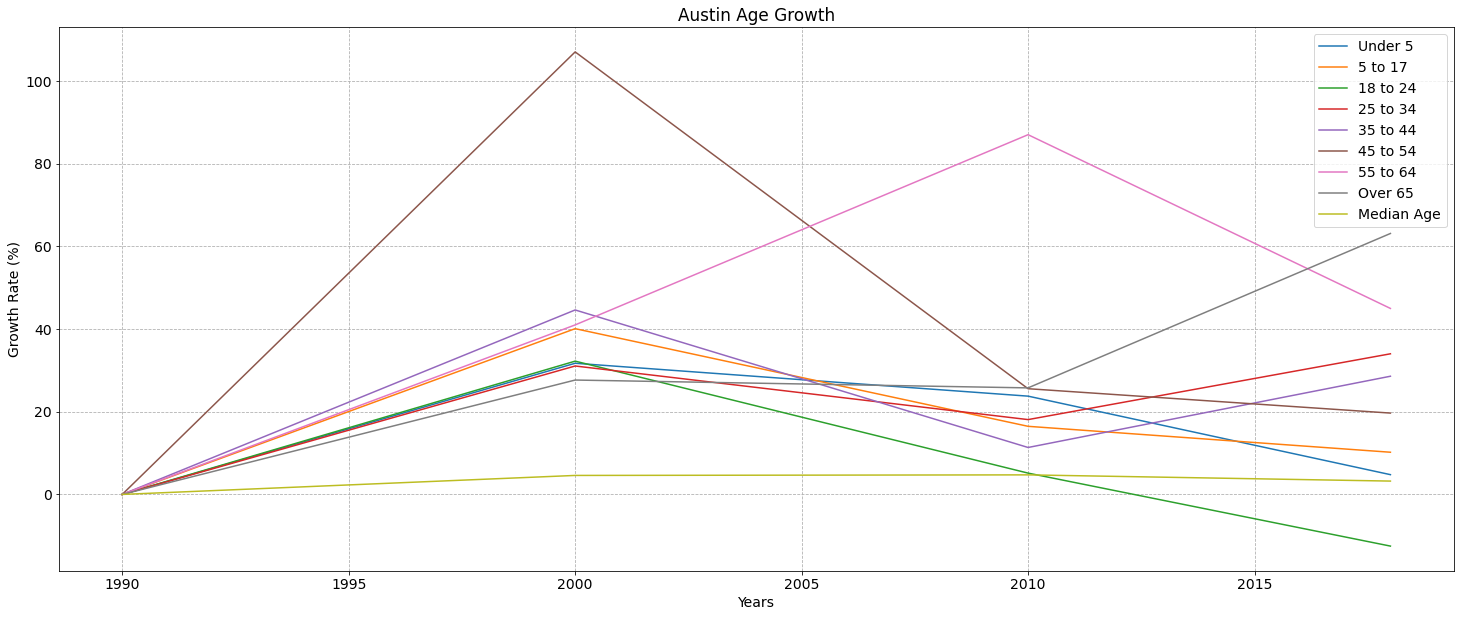

In [57]:
# Incorporate the other graph properties
plt.title("Austin Age Growth")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Years")
plt.grid(axis="both", linestyle="--")
plt.plot(age_growth)
plt.legend(labels=age_growth.columns)

plt.savefig(os.path.join("Images", "13 Age Growth.png"))
plt.show()

## Sex  

In [58]:
def sex(df):
    r = df["Data Item"][17:19].tolist()
    return r


def sex_year1(df):
    y = df["1990"][17:19].tolist()
    return y


def sex_year2(df):
    y = df["2000"][17:19].tolist()
    return y


def sex_year3(df):
    y = df["2010"][17:19].tolist()
    return y


def sex_year4(df):
    y = df["2018"][17:19].tolist()
    return y

In [59]:
demo3 = sex(df)
s1 = sex_year1(df)
s2 = sex_year2(df)
s3 = sex_year3(df)
s4 = sex_year4(df)
sex_demo = pd.DataFrame(
    [
        {"Year": 1990, demo3[0]: s1[0], demo3[1]: s1[1]},
        {"Year": 2000, demo3[0]: s2[0], demo3[1]: s2[1]},
        {"Year": 2010, demo3[0]: s3[0], demo3[1]: s3[1]},
        {"Year": 2018, demo3[0]: s4[0], demo3[1]: s4[1]},
    ]
).set_index("Year")
sex_demo

,Male,Female
Year,,
1990,49.93,50.07
2000,51.41,48.59
2010,50.57,49.43
2018,50.04,49.60


In [60]:
sex_demo = sex_demo.apply(pd.to_numeric)

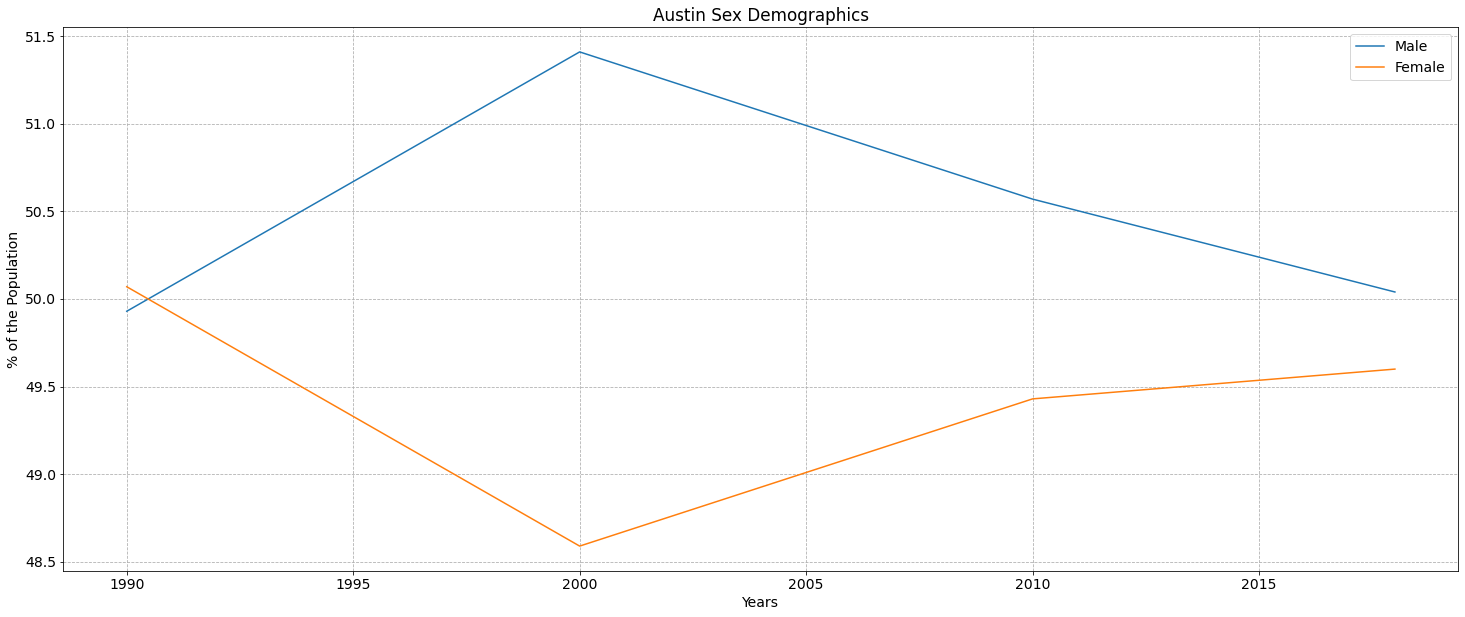

In [61]:
# Incorporate the other graph properties
plt.title("Austin Sex Demographics")
plt.ylabel("% of the Population")
plt.xlabel("Years")
plt.grid(axis="both", linestyle="--")
plt.plot(sex_demo)
plt.legend(labels=sex_demo.columns)

plt.savefig(os.path.join("Images", "14 Sex Demographics.png"))
plt.show()

In [62]:
sc1 = percent_to_units1990(df["1990"][17:19]).tolist()
sc2 = percent_to_units2000(df["2000"][17:19]).tolist()
sc3 = percent_to_units2010(df["2010"][17:19]).tolist()
sc4 = percent_to_units2018(df["2018"][17:19]).tolist()
sg1 = growth(sc2[0:2], sc1[0:2]).tolist()
sg2 = growth(sc3[0:2], sc2[0:2]).tolist()
sg3 = growth(sc4[0:2], sc3[0:2]).tolist()
sex_growth = pd.DataFrame(
    [
        {"Year": 1990, demo3[0]: 0, demo3[1]: 0},
        {"Year": 2000, demo3[0]: sg1[0], demo3[1]: sg1[1]},
        {"Year": 2010, demo3[0]: sg2[0], demo3[1]: sg2[1]},
        {"Year": 2018, demo3[0]: sg3[0], demo3[1]: sg3[1]},
    ]
).set_index("Year")
sex_growth

,Male,Female
Year,,
1990,0.000000,0.000000
2000,45.187186,36.839525
2010,18.416179,22.464272
2018,20.717270,22.415419


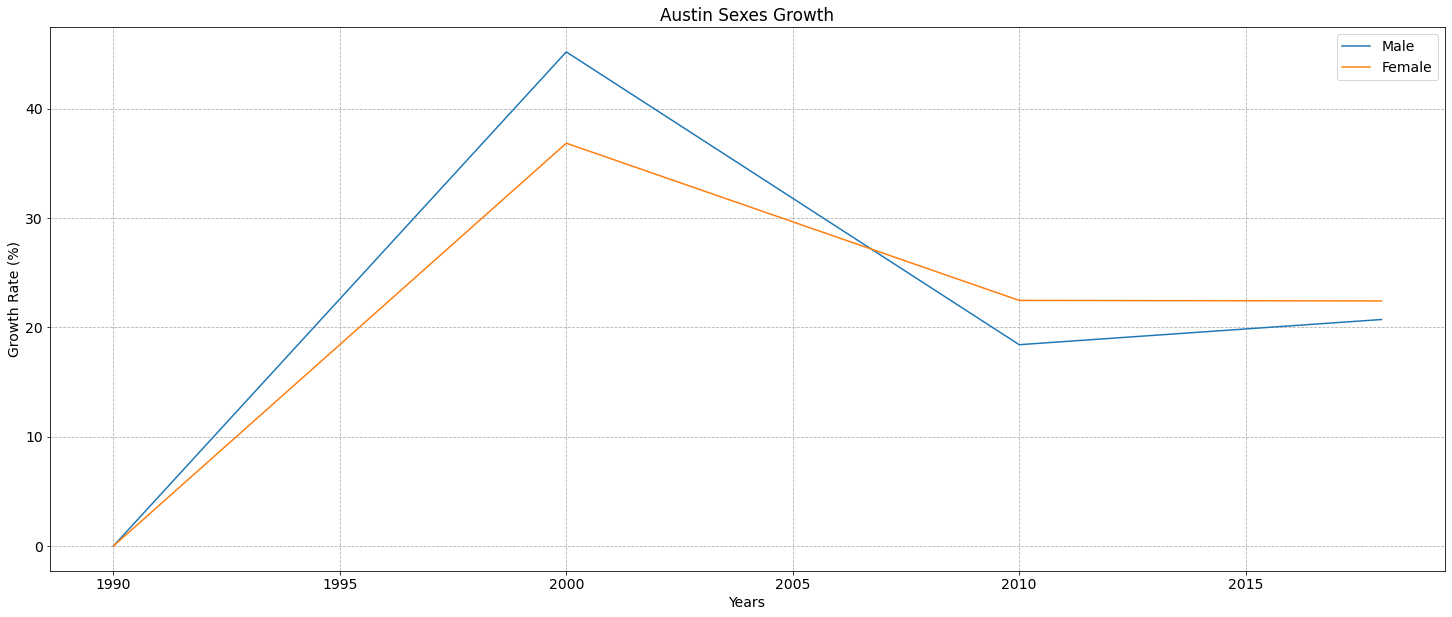

In [63]:
# Incorporate the other graph properties
plt.title("Austin Sexes Growth")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Years")
plt.grid(axis="both", linestyle="--")
plt.plot(sex_growth)
plt.legend(labels=sex_growth.columns)

plt.savefig(os.path.join("Images", "15 Sex Demographics Growth.png"))
plt.show()

## Social & Economics  

In [64]:
def soci_econ(df):
    r = df["Data Item"][19:29].tolist()
    return r


def soec_year1(df):
    y = df["1990"][19:29].tolist()
    return y


def soec_year2(df):
    y = df["2000"][19:29].tolist()
    return y


def soec_year3(df):
    y = df["2010"][19:29].tolist()
    return y


def soec_year4(df):
    y = df["2018"][19:29].tolist()
    return y

In [65]:
units = soci_econ(df)
e1 = soec_year1(df)
e2 = soec_year2(df)
e3 = soec_year3(df)
e4 = soec_year4(df)
housing = pd.DataFrame(
    [
        {
            "Year": 1990,
            units[0]: e1[0],
            units[1]: e1[1],
            units[2]: e1[2],
            units[9]: e1[9],
        },
        {
            "Year": 2000,
            units[0]: e2[0],
            units[1]: e2[1],
            units[2]: e2[2],
            units[9]: e2[9],
        },
        {
            "Year": 2010,
            units[0]: e3[0],
            units[1]: e3[1],
            units[2]: e3[2],
            units[9]: e3[9],
        },
        {
            "Year": 2018,
            units[0]: e4[0],
            units[1]: e4[1],
            units[2]: e4[2],
            units[9]: e4[9],
        },
    ]
).set_index("Year")
housing

,Occupied Units,Owner Occupied,Renter Occupied,Family Households
Year,,,,
1990,217054.0,77974.0,114174.0,104791.0
2000,276842.0,119102.0,146547.0,141589.0
2010,354241.0,146666.0,178226.0,168582.0
2018,425076.0,175016.0,215379.0,214238.0


In [66]:
median_income = pd.DataFrame(
    [
        {"Year": 1990, units[3]: e1[3]},
        {"Year": 2000, units[3]: e2[3]},
        {"Year": 2010, units[3]: e3[3]},
        {"Year": 2018, units[3]: e4[3]},
    ]
).set_index("Year")
median_income

,Median Household Income(inflation adj.)
Year,
1990,43399.0
2000,54450.0
2010,50132.0
2018,71543.0


In [67]:
poverty = pd.DataFrame(
    [
        {"Year": 1990, units[4]: e1[4], units[5]: e1[5]},
        {"Year": 2000, units[4]: e2[4], units[5]: e2[5]},
        {"Year": 2010, units[4]: e3[4], units[5]: e3[5]},
        {"Year": 2018, units[4]: e4[4], units[5]: e4[5]},
    ]
).set_index("Year")
poverty

,Poverty Rate,Vacancy Rate
Year,,
1990,17.9,11.5
2000,14.4,4.0
2010,18.4,8.3
2018,13.3,8.2


In [68]:
education = pd.DataFrame(
    [
        {"Year": 1990, units[7]: e1[7]},
        {"Year": 2000, units[7]: e2[7]},
        {"Year": 2010, units[7]: e3[7]},
        {"Year": 2018, units[7]: e4[7]},
    ]
).set_index("Year")
education

,Bachelor's Degree or Higher
Year,
1990,34.4
2000,40.4
2010,43.9
2018,54.1


In [69]:
size = pd.DataFrame(
    [
        {"Year": 1990, units[8]: e1[8]},
        {"Year": 2000, units[8]: e2[8]},
        {"Year": 2010, units[8]: e3[8]},
        {"Year": 2018, units[8]: e4[8]},
    ]
).set_index("Year")
size

,Average Household Size
Year,
1990,2.33
2000,2.40
2010,2.37
2018,2.40


In [70]:
housing = housing.apply(pd.to_numeric)
median_income = median_income.apply(pd.to_numeric)
poverty = poverty.apply(pd.to_numeric)
education = education.apply(pd.to_numeric)
size = size.apply(pd.to_numeric)

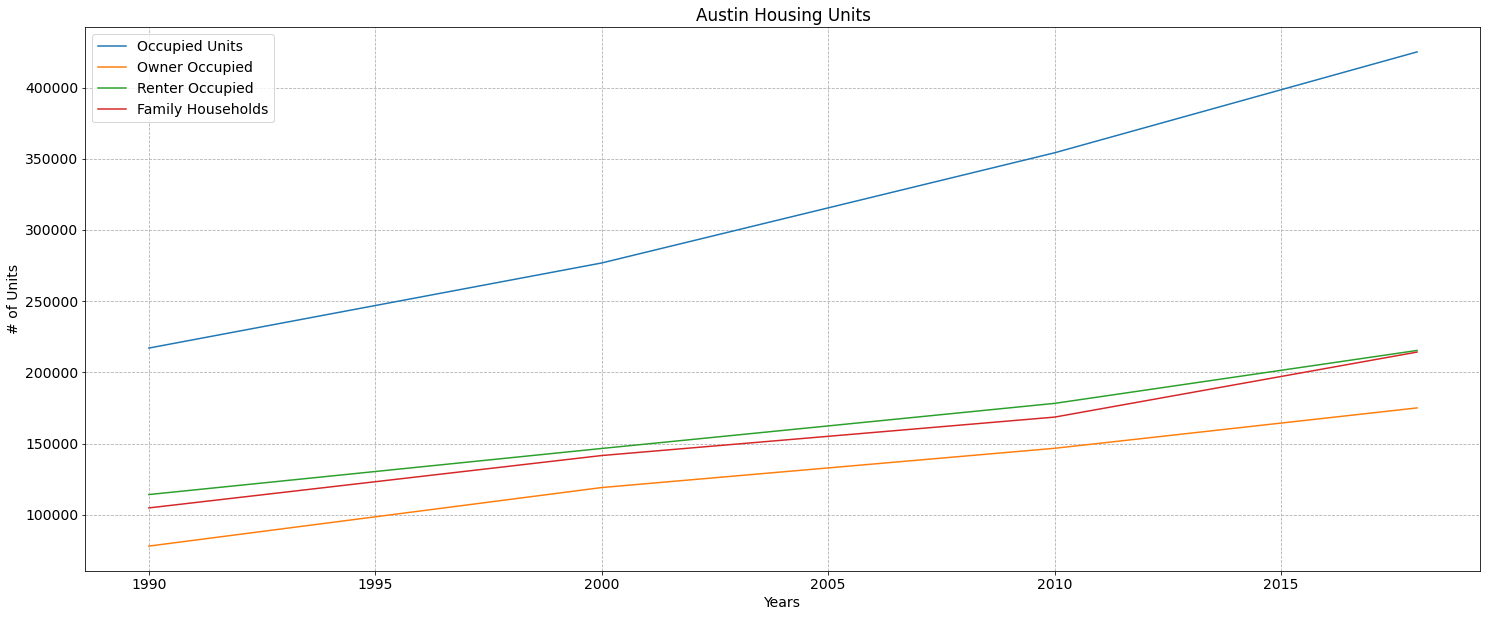

In [71]:
# Incorporate the other graph properties
plt.title("Austin Housing Units")
plt.ylabel("# of Units")
plt.xlabel("Years")
plt.grid(axis="both", linestyle="--")
plt.plot(housing)
plt.legend(labels=housing.columns)

plt.savefig(os.path.join("Images", "16 Housing Units.png"))
plt.show()

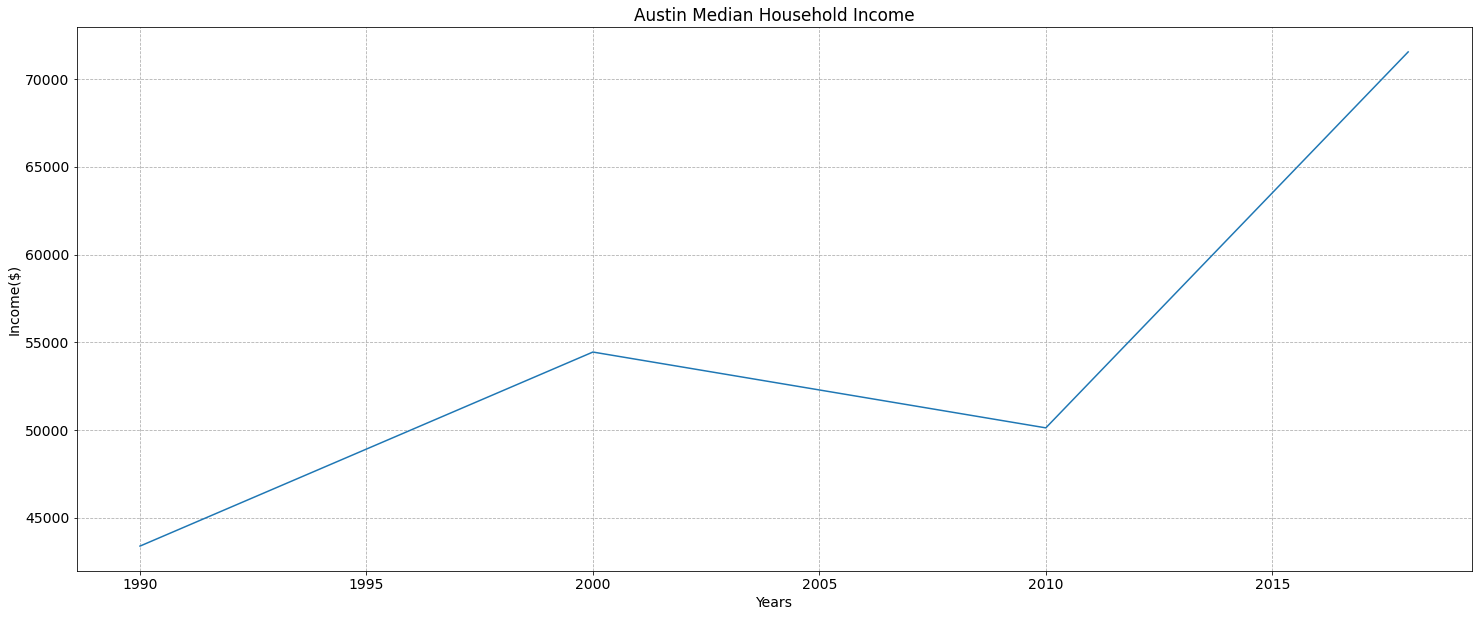

In [72]:
# Incorporate the other graph properties
plt.title("Austin Median Household Income")
plt.ylabel("Income($)")
plt.xlabel("Years")
plt.grid(axis="both", linestyle="--")
plt.plot(median_income)

plt.savefig(os.path.join("Images", "17 Median Income.png"))
plt.show()

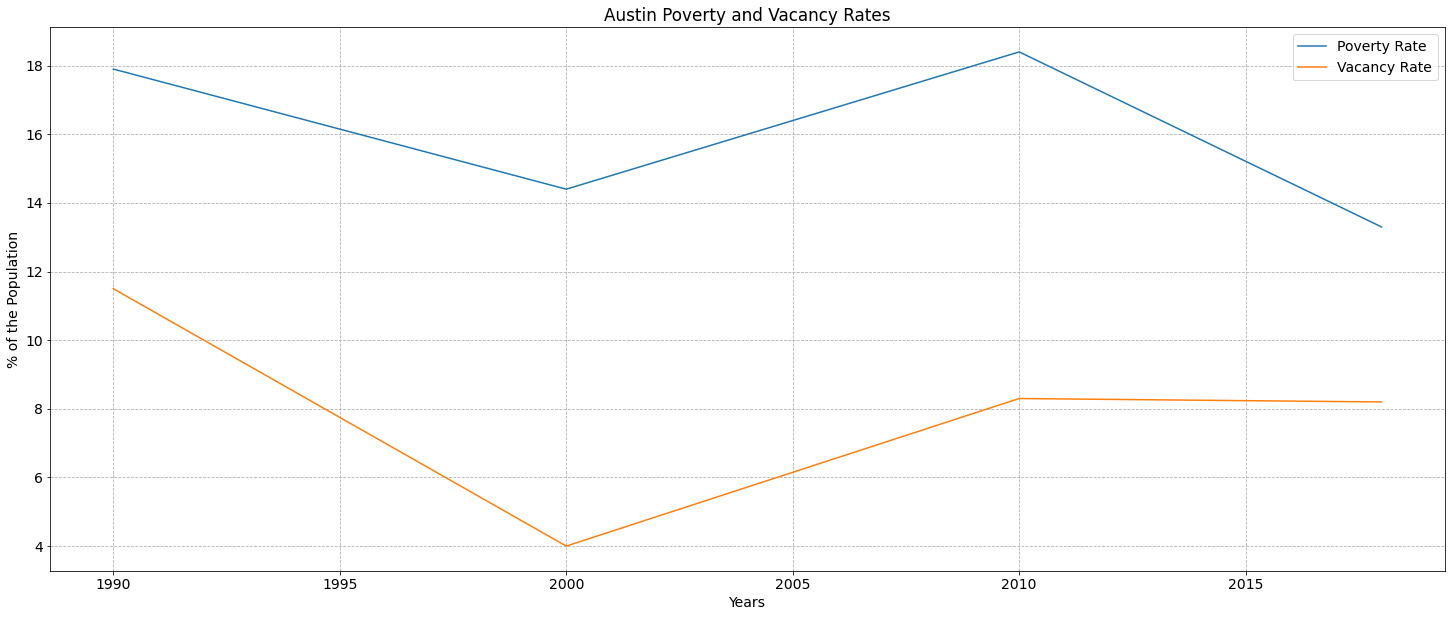

In [73]:
# Incorporate the other graph properties
plt.title("Austin Poverty and Vacancy Rates")
plt.ylabel("% of the Population")
plt.xlabel("Years")
plt.grid(axis="both", linestyle="--")
plt.plot(poverty)
plt.legend(labels=poverty.columns)

plt.savefig(os.path.join("Images", "18 Poverty Vacancy.png"))
plt.show()

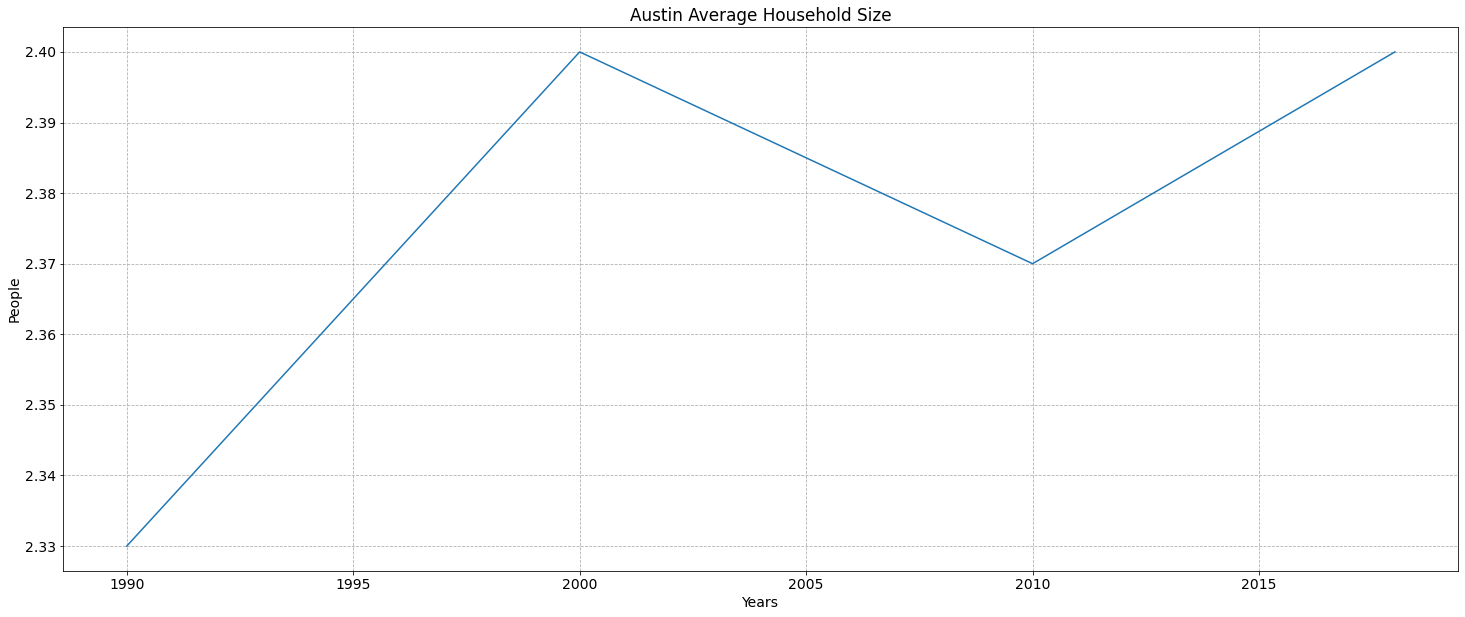

In [74]:
# Incorporate the other graph properties
plt.title("Austin Average Household Size")
plt.ylabel("People")
plt.xlabel("Years")
plt.grid(axis="both", linestyle="--")
plt.plot(size)

plt.savefig(os.path.join("Images", "19 Household Size.png"))
plt.show()

In [75]:
eg1 = growth(df["2000"][19:23], df["1990"][19:23]).tolist()
eg2 = growth(df["2010"][19:23], df["2000"][19:23]).tolist()
eg3 = growth(df["2018"][19:23], df["2010"][19:23]).tolist()
ec1 = percent_to_units1990(df["1990"][23:26]).tolist()
ec2 = percent_to_units2000(df["2000"][23:26]).tolist()
ec3 = percent_to_units2010(df["2010"][23:26]).tolist()
ec4 = percent_to_units2018(df["2018"][23:26]).tolist()
eg4 = growth(ec2[0:2], ec1[0:2]).tolist()
eg5 = growth(ec3[0:2], ec2[0:2]).tolist()
eg6 = growth(ec4[0:2], ec3[0:2]).tolist()
economic_growth = pd.DataFrame(
    [
        {
            "Year": 1990,
            units[0]: 0,
            units[1]: 0,
            units[2]: 0,
            units[3]: 0,
            units[4]: 0,
            units[5]: 0,
        },
        {
            "Year": 2000,
            units[0]: eg1[0],
            units[1]: eg1[1],
            units[2]: eg1[2],
            units[3]: eg1[3],
            units[4]: eg4[0],
            units[5]: eg4[1],
        },
        {
            "Year": 2010,
            units[0]: eg2[0],
            units[1]: eg2[1],
            units[2]: eg2[2],
            units[3]: eg2[3],
            units[4]: eg5[0],
            units[5]: eg5[1],
        },
        {
            "Year": 2018,
            units[0]: eg3[0],
            units[1]: eg3[1],
            units[2]: eg3[2],
            units[3]: eg3[3],
            units[4]: eg6[0],
            units[5]: eg6[1],
        },
    ]
).set_index("Year")
economic_growth

,Occupied Units,Owner Occupied,Renter Occupied,Median Household Income(inflation adj.),Poverty Rate,Vacancy Rate
Year,,,,,,
1990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000,27.545219,52.745787,28.354091,25.463720,13.436211,-50.953909
2010,27.957824,23.143188,21.616956,-7.930211,53.822911,149.795031
2018,19.996274,19.329633,20.846005,42.709248,-11.818217,20.526021


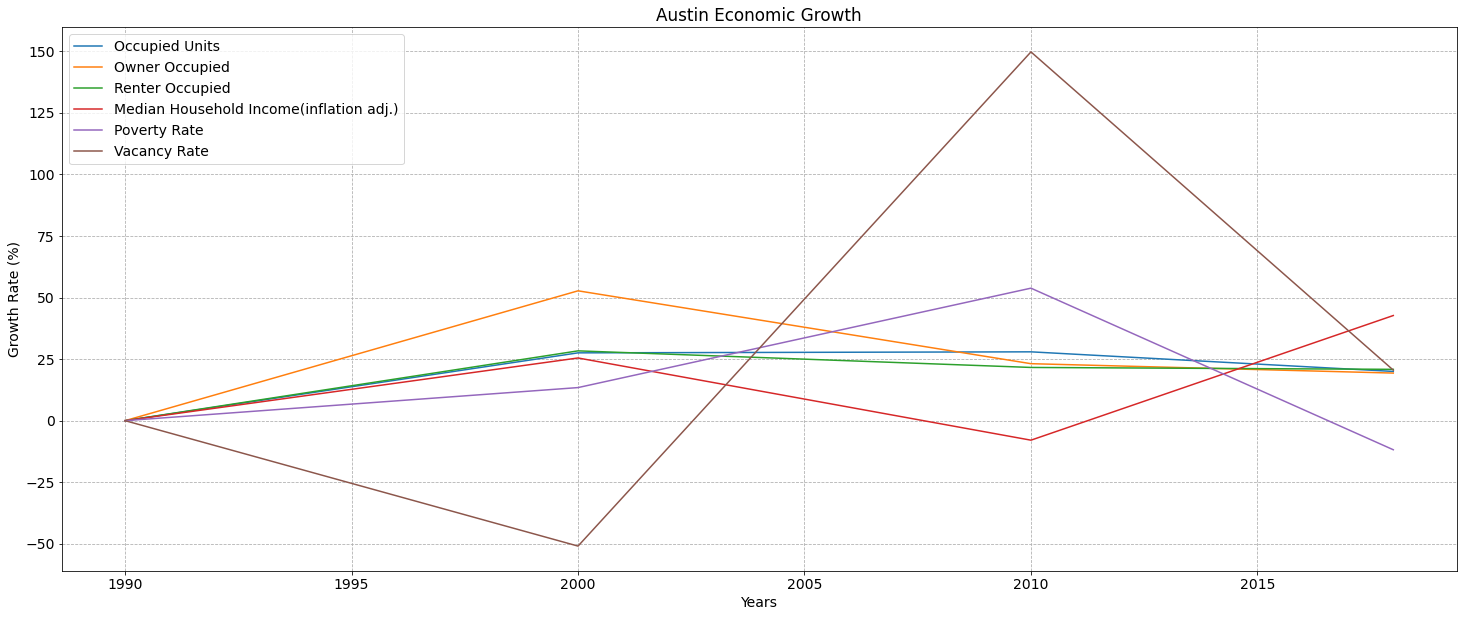

In [76]:
# Incorporate the other graph properties
plt.title("Austin Economic Growth")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Years")
plt.grid(axis="both", linestyle="--")
plt.plot(economic_growth)
plt.legend(labels=economic_growth.columns)

plt.savefig(os.path.join("Images", "20 Economic Growth.png"))
plt.show()

In [77]:
sog1 = growth(df["2000"][27:29], df["1990"][27:29]).tolist()
sog2 = growth(df["2010"][27:29], df["2000"][27:29]).tolist()
sog3 = growth(df["2018"][27:29], df["2010"][27:29]).tolist()
soc1 = percent_to_units1990(df["1990"][26])
soc2 = percent_to_units2000(df["2000"][26])
soc3 = percent_to_units2010(df["2010"][26])
soc4 = percent_to_units2018(df["2018"][26])
sog4 = growth(soc2, soc1)
sog5 = growth(soc3, soc2)
sog6 = growth(soc4, soc3)
social_growth = pd.DataFrame(
    [
        {"Year": 1990, units[7]: 0, units[8]: 0, units[9]: 0},
        {"Year": 2000, units[8]: sog1[0], units[9]: sog1[1], units[7]: sog4},
        {"Year": 2010, units[8]: sog2[0], units[9]: sog2[1], units[7]: sog5},
        {"Year": 2018, units[8]: sog3[0], units[9]: sog3[1], units[7]: sog6},
    ]
).set_index("Year")
social_growth

,Bachelor's Degree or Higher,Average Household Size,Family Households
Year,,,
1990,0.000000,0.000000,0.000000
2000,65.601846,3.004292,35.115611
2010,30.812380,-1.250000,19.064334
2018,50.341127,1.265823,27.082369


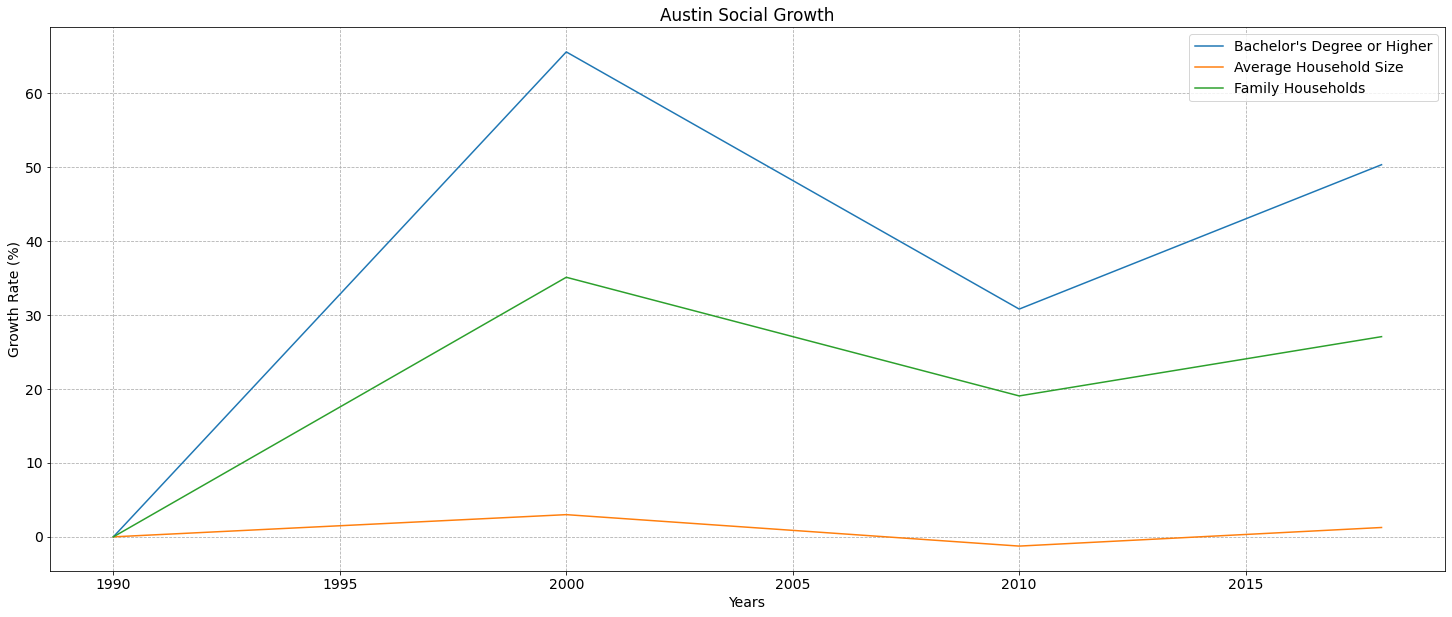

In [78]:
# Incorporate the other graph properties
plt.title("Austin Social Growth")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Years")
plt.grid(axis="both", linestyle="--")
plt.plot(social_growth)
plt.legend(labels=social_growth.columns)

plt.savefig(os.path.join("Images", "21 Social Growth.png"))
plt.show()

## Merge Housing, Population, Employment, and Demographic Data on Year  

In [79]:
population_df.head()

,Population,Population Change
Year,,
1990,465622,119732
2000,656562,190940
2010,806423,149861
2011,828694,22271
2012,854841,26147


In [80]:
zillow_series_annual_austin.head()

,Median Home Sale Value
Year,
2008,224100.0
2009,229000.0
2010,237350.0
2011,232900.0
2012,236650.0


In [81]:
labor_yearly_df.head()

,Labor Force,Employment,Employment Rate %,Unemployment,Unemployment Rate %
Year,,,,,
2010,469287,440312,93.8,28975,6.2
2011,483618,455426,94.2,28192,5.8
2012,498207,473046,94.9,25161,5.1
2013,513750,489962,95.4,23788,4.6
2014,528511,508899,96.3,19612,3.7


In [82]:
austin_data = pd.merge(
    left=population_df,
    right=zillow_series_annual_austin,
    left_index=True,
    right_index=True,
).merge(labor_yearly_df, left_index=True, right_index=True)
austin_data

,Population,Population Change,Median Home Sale Value,Labor Force,Employment,Employment Rate %,Unemployment,Unemployment Rate %
Year,,,,,,,,
2010,806423,149861,237350.0,469287,440312,93.8,28975,6.2
2011,828694,22271,232900.0,483618,455426,94.2,28192,5.8
2012,854841,26147,236650.0,498207,473046,94.9,25161,5.1
2013,875463,20622,263900.0,513750,489962,95.4,23788,4.6
2014,901734,26271,273000.0,528511,508899,96.3,19612,3.7
2015,921545,19811,277600.0,537448,521407,97.0,16041,3.0
2016,939768,18223,297250.0,555755,538632,96.9,17123,3.1
2017,951750,11982,308900.0,561212,544462,97.0,16750,3.0
2018,964254,12504,338900.0,579048,563154,97.3,15894,2.7


## Plot Population vs. Housing Data  

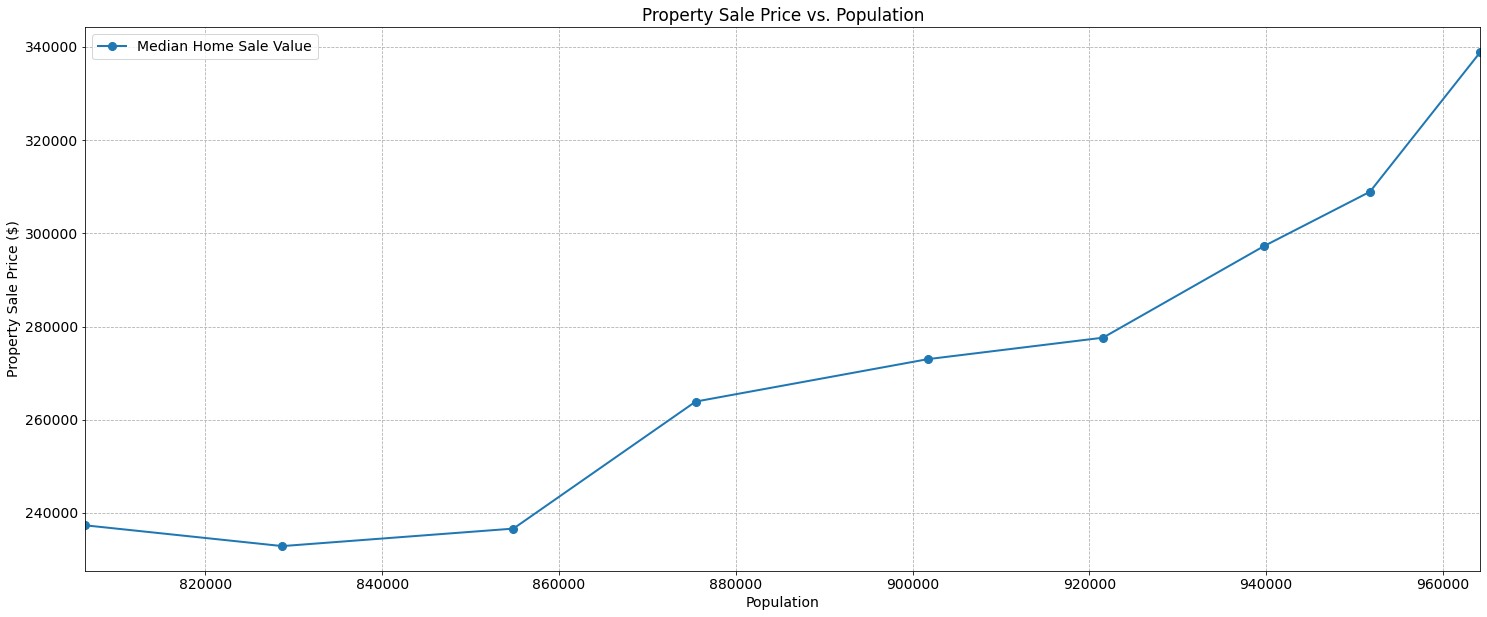

In [83]:
# Incorporate the other graph properties
austin_data.plot(
    x="Population", y="Median Home Sale Value", marker="o", linewidth=2, markersize=8
)
plt.title("Property Sale Price vs. Population")
plt.ylabel("Property Sale Price ($)")
plt.xlabel("Population")
plt.grid(axis="both", linestyle="--")
plt.legend(loc="upper left")

plt.savefig(os.path.join("Images", "22 Housing vs. Population.png"))
plt.show()

## Plot Population vs. Employment Data  

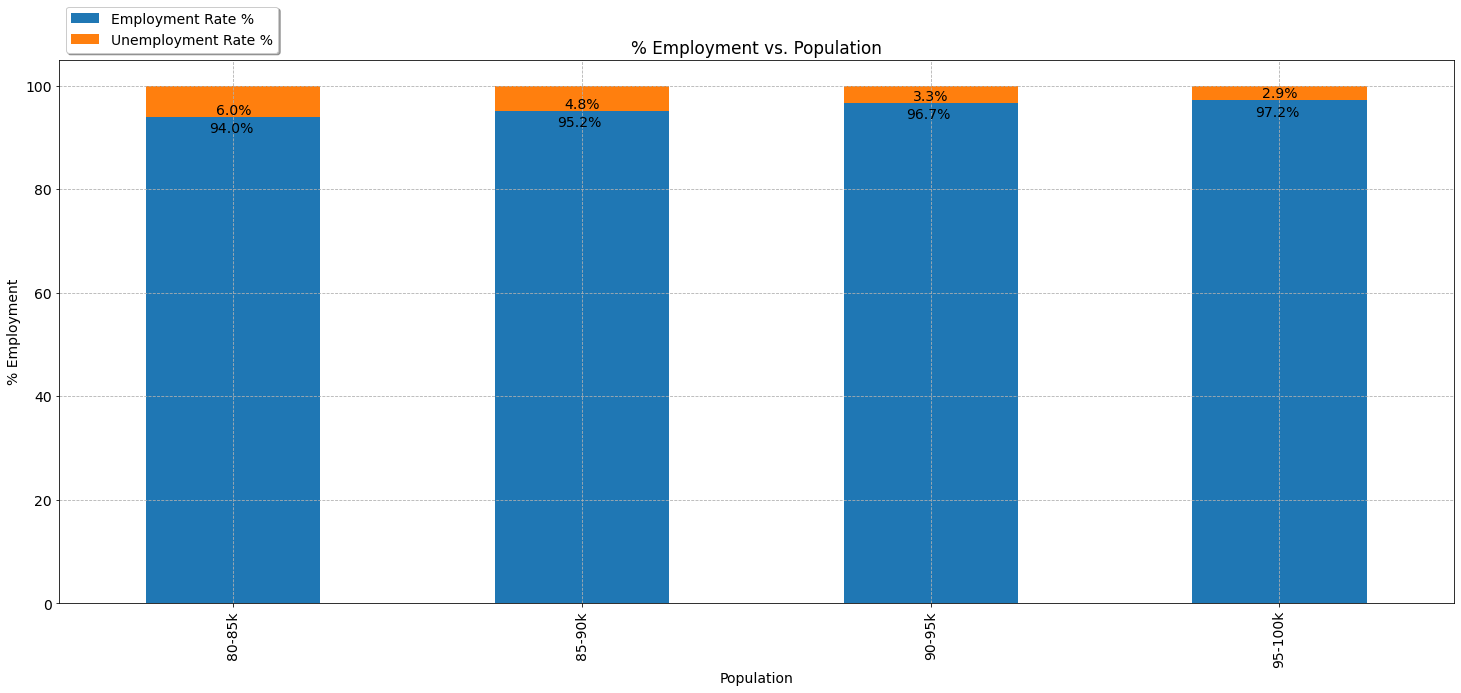

In [84]:
austin_data_bin = pd.cut(
    x=austin_data["Population"],
    bins=[800000, 850000, 900000, 950000, 1000000],
    labels=["80-85k", "85-90k", "90-95k", "95-100k"],
)
austin_data_bin
austin_data = austin_data.assign(pop_bin=austin_data_bin)
austin_data_group = austin_data.groupby("pop_bin")
austin_data_group_mean = austin_data_group[
    "Employment Rate %", "Unemployment Rate %"
].mean()
austin_data_group_mean

austin_data_group_mean.plot(kind="bar", stacked=True)
plt.title("% Employment vs. Population")
plt.ylabel("% Employment")
plt.xlabel("Population")
plt.grid(axis="both", linestyle="--")
plt.legend(
    loc="lower left", bbox_to_anchor=(0, 1.0), shadow=True,
)
for i in range(len(austin_data_group_mean)):
    plt.text(
        i - 0.07,
        austin_data_group_mean.iloc[i][0] - 3,
        f"{austin_data_group_mean.iloc[i][0]:.1f}%",
    )
    plt.text(
        i - 0.05,
        austin_data_group_mean.iloc[i][0] + 0.5,
        f"{austin_data_group_mean.iloc[i][1]:.1f}%",
    )

plt.savefig(os.path.join("Images", "23 Employment vs. Housing.png"))
plt.show()

## Export Housing, Population, Labor/Job, and Demographics Data to SQL Database  

In [85]:
population_df = population_df.reset_index()
zillow_series_annual_austin = zillow_series_annual_austin.reset_index()
labor_yearly_df = labor_yearly_df.reset_index()
race_demo_percent = race_demo_percent.reset_index()

In [86]:
USER = "root"
PASSWORD = "password"
HOST = "127.0.0.1"
PORT = "3306"
DATABASE = "austin_data"
engine = create_engine(f"mysql+pymysql://{USER}:{PASSWORD}@{HOST}:{PORT}")

try:
    engine.execute(f"CREATE DATABASE {DATABASE}")
    engine.execute(f"USE {DATABASE}")
except:
    print(f"Could not create database: {DATABASE}. It may already exist.")

engine.execute(f"USE {DATABASE}")
engine.execute(f"DROP TABLE IF EXISTS population")
engine.execute(f"DROP TABLE IF EXISTS median_home_sale_price")
engine.execute(f"DROP TABLE IF EXISTS employment")
engine.execute(f"DROP TABLE IF EXISTS demographics")

population_df.to_sql(name="population", con=engine, index=False)
zillow_series_annual_austin.to_sql(
    name="median_home_sale_price", con=engine, index=False
)
labor_yearly_df.to_sql(name="employment", con=engine, index=False)
race_demo_percent.to_sql(name="demographics", con=engine, index=False)

Could not create database: austin_data. It may already exist.
